In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df_ibuprofen = pd.read_csv('data/paracetamol.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
object     1
int64      1
dtype: int64
['quantity', 'kgPrice', 'dateUnix', 'dateIso']
length of columns : 4
quantity    2311
kgPrice     2311
dateUnix    2311
dateIso     2311
dtype: int64


,quantity,kgPrice,dateUnix,dateIso
0,1.0,0.750000,1483311600,01/01/2017
1,5986.0,3.039779,1483311600,01/01/2017
2,14137.2,3.356817,1483311600,01/01/2017
3,2500.0,6.887044,1483311600,01/01/2017
4,17789.2,3.401647,1483311600,01/01/2017


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
dataset = df_ibuprofen.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,quantity,kgPrice,dateUnix
0,1.0,0.750000,1483311600
1,5986.0,3.039779,1483311600
2,14137.2,3.356817,1483311600
3,2500.0,6.887044,1483311600
4,17789.2,3.401647,1483311600


In [4]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head(15)
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,3.448643,142727.8
1483398000,4.185645,34300.0
1483484400,4.050100,16000.0
1483570800,3.488540,92137.2
1483657200,3.203516,91000.0
1483743600,3.462037,68500.0
1483830000,4.802115,14000.0
1483916400,3.656298,55500.0
1484089200,4.226170,22500.0


In [5]:
column_names = ['weighted_avg_kgprice', 'quantity']

In [6]:
prices = np.array(dataset_weighted[column_names[0]])
volumes = np.array(dataset_weighted[column_names[1]])
#print(prices)
#print(volumes)

In [7]:
non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
[[3.44864252e+00 1.42727800e+05]
 [4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]]
4.8021150000000015
****************************************************************************************************
[[4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]
 [4.80211500e+00 1.40000000e+04]]
3.6562976577657653
****************************************************************************************************


In [8]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(546,)


In [9]:
data_dict = get_data_dict(d_list=[daily_prices, daily_volumes], 
                                windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
[[3.44864252e+00 1.42727800e+05]
 [4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]]
4.8021150000000015
****************************************************************************************************
[[4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]
 [4.80211500e+00 1.40000000e+04]]
3.6562976577657653
****************************************************************************************************


In [10]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_prices, norm_daily_volumes], 
                                windows=[6,8,12])

index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546


In [11]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.91967656  0.43837965]
 [-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]]
-0.8639204835988725
****************************************************************************************************
[[-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]
 [-0.86392048 -0.85894287]]
-0.9111222399603639
****************************************************************************************************


# BI-DIR LSTM

In [14]:
w = 6
# w = 8
# w = 12
batch_size = 32

In [15]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(4, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [16]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [17]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_paracetamol_price_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_price_norm.h5


In [18]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [19]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [20]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (432, 6, 2)
X_val: (108, 6, 2)


In [21]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[-0.91967656  0.43837965]
 [-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]]
-0.8639204835988725
**************************************************
[[-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]
 [-0.86392048 -0.85894287]]
-0.9111222399603639
**************************************************


In [22]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 432 samples, validate on 108 samples
Epoch 1/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.2901 - mean_absolute_error: 0.5346 - mean_squared_error: 0.2901 - mean_absolute_percentage_error: 59.9771
Epoch 00001: val_loss improved from inf to 0.24632, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 4s 9ms/step - loss: 0.2895 - mean_absolute_error: 0.5340 - mean_squared_error: 0.2895 - mean_absolute_percentage_error: 59.9231 - val_loss: 0.2463 - val_mean_absolute_error: 0.4949 - val_mean_squared_error: 0.2463 - val_mean_absolute_percentage_error: 59.3349
Epoch 2/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.2742 - mean_absolute_error: 0.5192 - mean_squared_error: 0.2742 - mean_absolute_percentage_error: 58.2641
Epoch 00002: val_loss improved from 0.24632 to 0.23226, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==================

416/432 [===========================>..] - ETA: 0s - loss: 0.1073 - mean_absolute_error: 0.3148 - mean_squared_error: 0.1073 - mean_absolute_percentage_error: 35.2216
Epoch 00014: val_loss improved from 0.09515 to 0.08525, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 799us/step - loss: 0.1071 - mean_absolute_error: 0.3148 - mean_squared_error: 0.1071 - mean_absolute_percentage_error: 35.2257 - val_loss: 0.0853 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.0853 - val_mean_absolute_percentage_error: 34.4898
Epoch 15/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0972 - mean_absolute_error: 0.2977 - mean_squared_error: 0.0972 - mean_absolute_percentage_error: 33.2852
Epoch 00015: val_loss improved from 0.08525 to 0.07592, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 1ms/step - loss: 0.0965 - mean_ab

416/432 [===========================>..] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.1129 - mean_squared_error: 0.0243 - mean_absolute_percentage_error: 12.5510
Epoch 00027: val_loss improved from 0.01502 to 0.01279, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 794us/step - loss: 0.0238 - mean_absolute_error: 0.1119 - mean_squared_error: 0.0238 - mean_absolute_percentage_error: 12.4375 - val_loss: 0.0128 - val_mean_absolute_error: 0.0975 - val_mean_squared_error: 0.0128 - val_mean_absolute_percentage_error: 11.6376
Epoch 28/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0222 - mean_absolute_percentage_error: 11.6144
Epoch 00028: val_loss improved from 0.01279 to 0.01095, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 799us/step - loss: 0.0217 - mean_

416/432 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0146 - mean_absolute_percentage_error: 7.7721
Epoch 00040: val_loss improved from 0.00407 to 0.00394, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 803us/step - loss: 0.0144 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0144 - mean_absolute_percentage_error: 7.7643 - val_loss: 0.0039 - val_mean_absolute_error: 0.0504 - val_mean_squared_error: 0.0039 - val_mean_absolute_percentage_error: 6.0431
Epoch 41/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0146 - mean_absolute_percentage_error: 7.7491
Epoch 00041: val_loss improved from 0.00394 to 0.00381, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 861us/step - loss: 0.0143 - mean_abso

Epoch 54/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0625 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 7.0243
Epoch 00054: val_loss improved from 0.00295 to 0.00290, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 843us/step - loss: 0.0132 - mean_absolute_error: 0.0624 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 7.0135 - val_loss: 0.0029 - val_mean_absolute_error: 0.0439 - val_mean_squared_error: 0.0029 - val_mean_absolute_percentage_error: 5.2755
Epoch 55/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0622 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 6.9853
Epoch 00055: val_loss improved from 0.00290 to 0.00284, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 0.01

416/432 [===========================>..] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0555 - mean_squared_error: 0.0124 - mean_absolute_percentage_error: 6.2536
Epoch 00067: val_loss improved from 0.00222 to 0.00217, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 891us/step - loss: 0.0122 - mean_absolute_error: 0.0557 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 6.2691 - val_loss: 0.0022 - val_mean_absolute_error: 0.0386 - val_mean_squared_error: 0.0022 - val_mean_absolute_percentage_error: 4.6405
Epoch 68/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0547 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 6.1579
Epoch 00068: val_loss improved from 0.00217 to 0.00213, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 769us/step - loss: 0.0121 - mean_abso

Epoch 00080: val_loss improved from 0.00167 to 0.00165, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 829us/step - loss: 0.0113 - mean_absolute_error: 0.0497 - mean_squared_error: 0.0113 - mean_absolute_percentage_error: 5.5999 - val_loss: 0.0016 - val_mean_absolute_error: 0.0329 - val_mean_squared_error: 0.0016 - val_mean_absolute_percentage_error: 3.9640
Epoch 81/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0496 - mean_squared_error: 0.0116 - mean_absolute_percentage_error: 5.5824
Epoch 00081: val_loss improved from 0.00165 to 0.00162, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 725us/step - loss: 0.0113 - mean_absolute_error: 0.0493 - mean_squared_error: 0.0113 - mean_absolute_percentage_error: 5.5593 - val_loss: 0.0016 - val_mean_absolute_error: 0.0326 - val_mean_squared_error

Epoch 94/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0459 - mean_squared_error: 0.0112 - mean_absolute_percentage_error: 5.1777
Epoch 00094: val_loss improved from 0.00140 to 0.00139, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 803us/step - loss: 0.0108 - mean_absolute_error: 0.0452 - mean_squared_error: 0.0108 - mean_absolute_percentage_error: 5.0981 - val_loss: 0.0014 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0014 - val_mean_absolute_percentage_error: 3.5749
Epoch 95/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0457 - mean_squared_error: 0.0112 - mean_absolute_percentage_error: 5.1586
Epoch 00095: val_loss improved from 0.00139 to 0.00139, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 796us/step - loss: 0.01

384/432 [=========================>....] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0433 - mean_squared_error: 0.0117 - mean_absolute_percentage_error: 4.8943
Epoch 00107: val_loss did not improve from 0.00129
432/432 [==============================] - 0s 796us/step - loss: 0.0106 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 4.8164 - val_loss: 0.0013 - val_mean_absolute_error: 0.0283 - val_mean_squared_error: 0.0013 - val_mean_absolute_percentage_error: 3.4184
Epoch 108/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0423 - mean_squared_error: 0.0109 - mean_absolute_percentage_error: 4.7747
Epoch 00108: val_loss improved from 0.00129 to 0.00128, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 826us/step - loss: 0.0106 - mean_absolute_error: 0.0424 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 

Epoch 121/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0115 - mean_absolute_percentage_error: 4.6970
Epoch 00121: val_loss improved from 0.00123 to 0.00123, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0104 - mean_absolute_percentage_error: 4.5989 - val_loss: 0.0012 - val_mean_absolute_error: 0.0273 - val_mean_squared_error: 0.0012 - val_mean_absolute_percentage_error: 3.2924
Epoch 122/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0107 - mean_absolute_percentage_error: 4.5335
Epoch 00122: val_loss improved from 0.00123 to 0.00122, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.0104

Epoch 135/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0395 - mean_squared_error: 0.0113 - mean_absolute_percentage_error: 4.4779   
Epoch 00135: val_loss did not improve from 0.00119
432/432 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0394 - mean_squared_error: 0.0103 - mean_absolute_percentage_error: 4.4500 - val_loss: 0.0012 - val_mean_absolute_error: 0.0266 - val_mean_squared_error: 0.0012 - val_mean_absolute_percentage_error: 3.2177
Epoch 136/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0393 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 4.4347
Epoch 00136: val_loss improved from 0.00119 to 0.00118, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0392 - mean_squared_error: 0.0103 - mean_absolute_perc

Epoch 149/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0384 - mean_squared_error: 0.0104 - mean_absolute_percentage_error: 4.3173
Epoch 00149: val_loss improved from 0.00114 to 0.00114, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 970us/step - loss: 0.0102 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0102 - mean_absolute_percentage_error: 4.3259 - val_loss: 0.0011 - val_mean_absolute_error: 0.0260 - val_mean_squared_error: 0.0011 - val_mean_absolute_percentage_error: 3.1417
Epoch 150/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0105 - mean_absolute_percentage_error: 4.3342
Epoch 00150: val_loss did not improve from 0.00114
432/432 [==============================] - 0s 719us/step - loss: 0.0102 - mean_absolute_error: 0.0385 - mean_squared_error: 0.0102 - mean_absolute_per

Epoch 163/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0111 - mean_absolute_percentage_error: 4.2065     
Epoch 00163: val_loss improved from 0.00110 to 0.00110, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 887us/step - loss: 0.0101 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0101 - mean_absolute_percentage_error: 4.2247 - val_loss: 0.0011 - val_mean_absolute_error: 0.0255 - val_mean_squared_error: 0.0011 - val_mean_absolute_percentage_error: 3.0833
Epoch 164/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0376 - mean_squared_error: 0.0104 - mean_absolute_percentage_error: 4.2496
Epoch 00164: val_loss improved from 0.00110 to 0.00110, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 831us/step - los

416/432 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0323 - mean_squared_error: 0.0019 - mean_absolute_percentage_error: 3.7149
Epoch 00177: val_loss improved from 0.00107 to 0.00106, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 824us/step - loss: 0.0100 - mean_absolute_error: 0.0366 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 4.1436 - val_loss: 0.0011 - val_mean_absolute_error: 0.0250 - val_mean_squared_error: 0.0011 - val_mean_absolute_percentage_error: 3.0293
Epoch 178/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0371 - mean_squared_error: 0.0104 - mean_absolute_percentage_error: 4.1995
Epoch 00178: val_loss did not improve from 0.00106
432/432 [==============================] - 0s 784us/step - loss: 0.0100 - mean_absolute_error: 0.0367 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 

416/432 [===========================>..] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0359 - mean_squared_error: 0.0103 - mean_absolute_percentage_error: 4.0709
Epoch 00191: val_loss improved from 0.00103 to 0.00102, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 838us/step - loss: 0.0100 - mean_absolute_error: 0.0356 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 4.0309 - val_loss: 0.0010 - val_mean_absolute_error: 0.0246 - val_mean_squared_error: 0.0010 - val_mean_absolute_percentage_error: 2.9790
Epoch 192/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0363 - mean_squared_error: 0.0103 - mean_absolute_percentage_error: 4.1115
Epoch 00192: val_loss did not improve from 0.00102
432/432 [==============================] - 0s 774us/step - loss: 0.0099 - mean_absolute_error: 0.0357 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 

432/432 [==============================] - 0s 937us/step - loss: 0.0099 - mean_absolute_error: 0.0351 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.9723 - val_loss: 9.9968e-04 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 9.9968e-04 - val_mean_absolute_percentage_error: 2.9412
Epoch 206/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0102 - mean_absolute_percentage_error: 4.0045
Epoch 00206: val_loss improved from 0.00100 to 0.00099, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 837us/step - loss: 0.0099 - mean_absolute_error: 0.0350 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.9636 - val_loss: 9.9422e-04 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 9.9422e-04 - val_mean_absolute_percentage_error: 2.9336
Epoch 207/1000
416/432 [===========================>..] - ETA: 

416/432 [===========================>..] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0101 - mean_absolute_percentage_error: 3.8618     
Epoch 00219: val_loss improved from 0.00096 to 0.00096, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 824us/step - loss: 0.0098 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.8623 - val_loss: 9.6230e-04 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 9.6230e-04 - val_mean_absolute_percentage_error: 2.8893
Epoch 220/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0102 - mean_absolute_percentage_error: 3.9316
Epoch 00220: val_loss did not improve from 0.00096
432/432 [==============================] - 0s 743us/step - loss: 0.0098 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0098 - mean_absolute_perce

Epoch 00233: val_loss improved from 0.00094 to 0.00093, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 856us/step - loss: 0.0098 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.8246 - val_loss: 9.3348e-04 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 9.3348e-04 - val_mean_absolute_percentage_error: 2.8569
Epoch 234/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0109 - mean_absolute_percentage_error: 3.9265     
Epoch 00234: val_loss did not improve from 0.00093
432/432 [==============================] - 0s 829us/step - loss: 0.0098 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.8309 - val_loss: 9.4514e-04 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 9.4514e-04 - val_mean_absolute_percentage_error: 2.8726
Epoch 2

Epoch 248/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0331 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 3.7457
Epoch 00248: val_loss improved from 0.00091 to 0.00091, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 857us/step - loss: 0.0097 - mean_absolute_error: 0.0334 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.7860 - val_loss: 9.0546e-04 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 9.0546e-04 - val_mean_absolute_percentage_error: 2.8334
Epoch 249/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0329 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.6736
Epoch 00249: val_loss did not improve from 0.00091
432/432 [==============================] - 0s 729us/step - loss: 0.0097 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0097 - mean_abso

416/432 [===========================>..] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0016 - mean_absolute_percentage_error: 3.3201
Epoch 00262: val_loss improved from 0.00088 to 0.00088, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 825us/step - loss: 0.0097 - mean_absolute_error: 0.0329 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.7311 - val_loss: 8.7914e-04 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 8.7914e-04 - val_mean_absolute_percentage_error: 2.8063
Epoch 263/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.6287
Epoch 00263: val_loss did not improve from 0.00088
432/432 [==============================] - 0s 942us/step - loss: 0.0097 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0097 - mean_absolute_percentage

416/432 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 3.7281     
Epoch 00276: val_loss did not improve from 0.00086
432/432 [==============================] - 0s 769us/step - loss: 0.0097 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.7294 - val_loss: 8.6854e-04 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 8.6854e-04 - val_mean_absolute_percentage_error: 2.7962
Epoch 277/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0334 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 3.7830
Epoch 00277: val_loss did not improve from 0.00086
432/432 [==============================] - 0s 782us/step - loss: 0.0097 - mean_absolute_error: 0.0329 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.7237 - val_loss: 8.6284e-04 - val_mean_absolute_error: 0.0230 - val_

416/432 [===========================>..] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0322 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.6349
Epoch 00290: val_loss did not improve from 0.00084
432/432 [==============================] - 0s 768us/step - loss: 0.0096 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.6633 - val_loss: 8.4098e-04 - val_mean_absolute_error: 0.0226 - val_mean_squared_error: 8.4098e-04 - val_mean_absolute_percentage_error: 2.7467
Epoch 291/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 3.7180
Epoch 00291: val_loss did not improve from 0.00084
432/432 [==============================] - 0s 773us/step - loss: 0.0096 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.6625 - val_loss: 8.4308e-04 - val_mean_absolute_error: 0.0227 - val_mean_

Epoch 305/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0327 - mean_squared_error: 0.0100 - mean_absolute_percentage_error: 3.6945
Epoch 00305: val_loss did not improve from 0.00082
432/432 [==============================] - 0s 769us/step - loss: 0.0096 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.6674 - val_loss: 8.2777e-04 - val_mean_absolute_error: 0.0225 - val_mean_squared_error: 8.2777e-04 - val_mean_absolute_percentage_error: 2.7256
Epoch 306/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0316 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.5695      
Epoch 00306: val_loss improved from 0.00082 to 0.00082, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 0.0096 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0096 - mea

416/432 [===========================>..] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0316 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.5748     
Epoch 00319: val_loss did not improve from 0.00081
432/432 [==============================] - 0s 764us/step - loss: 0.0096 - mean_absolute_error: 0.0314 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.5578 - val_loss: 8.1629e-04 - val_mean_absolute_error: 0.0222 - val_mean_squared_error: 8.1629e-04 - val_mean_absolute_percentage_error: 2.6955
Epoch 320/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0314 - mean_squared_error: 0.0099 - mean_absolute_percentage_error: 3.5543
Epoch 00320: val_loss did not improve from 0.00081
432/432 [==============================] - 0s 768us/step - loss: 0.0096 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.5692 - val_loss: 8.1351e-04 - val_mean_absolute_error: 0.0221 - val_

Epoch 334/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0312 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.5270
Epoch 00334: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 764us/step - loss: 0.0095 - mean_absolute_error: 0.0312 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 3.5297 - val_loss: 8.0384e-04 - val_mean_absolute_error: 0.0219 - val_mean_squared_error: 8.0384e-04 - val_mean_absolute_percentage_error: 2.6566
Epoch 335/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.4965     
Epoch 00335: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 763us/step - loss: 0.0095 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 3.4973 - val_loss: 8.0380e-04 - val_mean_absolute_error

Epoch 349/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4975
Epoch 00349: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 742us/step - loss: 0.0095 - mean_absolute_error: 0.0310 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 3.5046 - val_loss: 8.4100e-04 - val_mean_absolute_error: 0.0226 - val_mean_squared_error: 8.4100e-04 - val_mean_absolute_percentage_error: 2.7428
Epoch 350/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0318 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.5953
Epoch 00350: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 756us/step - loss: 0.0095 - mean_absolute_error: 0.0317 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 3.5872 - val_loss: 8.2762e-04 - val_mean_absolute_error: 0.0

416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.5040     
Epoch 00364: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 808us/step - loss: 0.0094 - mean_absolute_error: 0.0308 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4832 - val_loss: 8.2377e-04 - val_mean_absolute_error: 0.0220 - val_mean_squared_error: 8.2377e-04 - val_mean_absolute_percentage_error: 2.6685
Epoch 365/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0302 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.4291     
Epoch 00365: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 769us/step - loss: 0.0095 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 3.4305 - val_loss: 8.2136e-04 - val_mean_absolute_error: 0.0218 -

416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0310 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.5092      
Epoch 00379: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0305 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4569 - val_loss: 8.1574e-04 - val_mean_absolute_error: 0.0218 - val_mean_squared_error: 8.1574e-04 - val_mean_absolute_percentage_error: 2.6506
Epoch 380/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0306 - mean_squared_error: 0.0104 - mean_absolute_percentage_error: 3.4572  
Epoch 00380: val_loss did not improve from 0.00080
432/432 [==============================] - 1s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0305 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4558 - val_loss: 8.1453e-04 - val_mean_absolute_error: 0.0218 - val_m

416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0306 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.4738
Epoch 00394: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 767us/step - loss: 0.0094 - mean_absolute_error: 0.0302 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4186 - val_loss: 8.0677e-04 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 8.0677e-04 - val_mean_absolute_percentage_error: 2.6382
Epoch 395/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0308 - mean_squared_error: 0.0098 - mean_absolute_percentage_error: 3.4859
Epoch 00395: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 773us/step - loss: 0.0094 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4333 - val_loss: 8.0684e-04 - val_mean_absolute_error: 0.0217 - val_mean_

416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4369
Epoch 00409: val_loss did not improve from 0.00080
432/432 [==============================] - 0s 756us/step - loss: 0.0094 - mean_absolute_error: 0.0300 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4033 - val_loss: 8.0290e-04 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 8.0290e-04 - val_mean_absolute_percentage_error: 2.6352
Epoch 410/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0301 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4090     
Epoch 00410: val_loss improved from 0.00080 to 0.00080, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 0.0094 - mean_absolute_error: 0.0299 - mean_squared_error: 0.0094 - mean_absolute_perce

Epoch 00423: val_loss improved from 0.00079 to 0.00079, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 825us/step - loss: 0.0094 - mean_absolute_error: 0.0301 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4045 - val_loss: 7.9396e-04 - val_mean_absolute_error: 0.0215 - val_mean_squared_error: 7.9396e-04 - val_mean_absolute_percentage_error: 2.6115
Epoch 424/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.3715
Epoch 00424: val_loss did not improve from 0.00079
432/432 [==============================] - 0s 778us/step - loss: 0.0094 - mean_absolute_error: 0.0299 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.3835 - val_loss: 7.9804e-04 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 7.9804e-04 - val_mean_absolute_percentage_error: 2.6309
Epoch 425/10

Epoch 438/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4234
Epoch 00438: val_loss did not improve from 0.00079
432/432 [==============================] - 0s 742us/step - loss: 0.0094 - mean_absolute_error: 0.0302 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.4198 - val_loss: 7.9048e-04 - val_mean_absolute_error: 0.0215 - val_mean_squared_error: 7.9048e-04 - val_mean_absolute_percentage_error: 2.6117
Epoch 439/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0254 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 2.9373     
Epoch 00439: val_loss improved from 0.00079 to 0.00079, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 800us/step - loss: 0.0094 - mean_absolute_error: 0.0294 - mean_squared_error: 0.0094 - mean

Epoch 453/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0302 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4171
Epoch 00453: val_loss improved from 0.00079 to 0.00078, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 832us/step - loss: 0.0094 - mean_absolute_error: 0.0299 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.3814 - val_loss: 7.8427e-04 - val_mean_absolute_error: 0.0213 - val_mean_squared_error: 7.8427e-04 - val_mean_absolute_percentage_error: 2.5910
Epoch 454/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0299 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.3929
Epoch 00454: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 783us/step - loss: 0.0094 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0094 - mean_abso

Epoch 468/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0268 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 3.0742     
Epoch 00468: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 748us/step - loss: 0.0094 - mean_absolute_error: 0.0311 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.5123 - val_loss: 8.0122e-04 - val_mean_absolute_error: 0.0219 - val_mean_squared_error: 8.0122e-04 - val_mean_absolute_percentage_error: 2.6528
Epoch 469/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0313 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.5333     
Epoch 00469: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 757us/step - loss: 0.0094 - mean_absolute_error: 0.0312 - mean_squared_error: 0.0094 - mean_absolute_percentage_error: 3.5203 - val_loss: 8.2052e-04 - val_mean_absolute_

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3466
Epoch 00483: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 777us/step - loss: 0.0093 - mean_absolute_error: 0.0293 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3228 - val_loss: 7.8344e-04 - val_mean_absolute_error: 0.0212 - val_mean_squared_error: 7.8344e-04 - val_mean_absolute_percentage_error: 2.5806
Epoch 484/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0300 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.3982
Epoch 00484: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 785us/step - loss: 0.0093 - mean_absolute_error: 0.0299 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3849 - val_loss: 7.8471e-04 - val_mean_absolute_error: 0.0214 - val_mean_

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3685     
Epoch 00498: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 764us/step - loss: 0.0093 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3756 - val_loss: 7.8872e-04 - val_mean_absolute_error: 0.0214 - val_mean_squared_error: 7.8872e-04 - val_mean_absolute_percentage_error: 2.6041
Epoch 499/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3478
Epoch 00499: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 754us/step - loss: 0.0093 - mean_absolute_error: 0.0294 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3367 - val_loss: 7.8620e-04 - val_mean_absolute_error: 0.0213 - val_

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3488
Epoch 00513: val_loss improved from 0.00078 to 0.00078, saving model to models/bidirlstm_multivariate_model_paracetamol_price_norm.h5
432/432 [==============================] - 0s 839us/step - loss: 0.0093 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3073 - val_loss: 7.8097e-04 - val_mean_absolute_error: 0.0211 - val_mean_squared_error: 7.8097e-04 - val_mean_absolute_percentage_error: 2.5717
Epoch 514/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3577
Epoch 00514: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 776us/step - loss: 0.0093 - mean_absolute_error: 0.0294 - mean_squared_error: 0.0093 - mean_absolute_percentage

Epoch 528/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0300 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3892     
Epoch 00528: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 744us/step - loss: 0.0093 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3759 - val_loss: 7.8252e-04 - val_mean_absolute_error: 0.0213 - val_mean_squared_error: 7.8252e-04 - val_mean_absolute_percentage_error: 2.5917
Epoch 529/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0294 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3379     
Epoch 00529: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 767us/step - loss: 0.0093 - mean_absolute_error: 0.0291 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3026 - val_loss: 7.8141e-04 - val_mean_absolute_

Epoch 543/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0244 - mean_squared_error: 0.0012 - mean_absolute_percentage_error: 2.8267     
Epoch 00543: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 764us/step - loss: 0.0093 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.2643 - val_loss: 7.8476e-04 - val_mean_absolute_error: 0.0210 - val_mean_squared_error: 7.8476e-04 - val_mean_absolute_percentage_error: 2.5597
Epoch 544/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0097 - mean_absolute_percentage_error: 3.4983     
Epoch 00544: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 768us/step - loss: 0.0093 - mean_absolute_error: 0.0306 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.4540 - val_loss: 8.2433e-04 - val_mean_absolute_

Epoch 558/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3455
Epoch 00558: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 793us/step - loss: 0.0093 - mean_absolute_error: 0.0293 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3149 - val_loss: 7.8692e-04 - val_mean_absolute_error: 0.0213 - val_mean_squared_error: 7.8692e-04 - val_mean_absolute_percentage_error: 2.5940
Epoch 559/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3138     
Epoch 00559: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 766us/step - loss: 0.0093 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3090 - val_loss: 7.8391e-04 - val_mean_absolute_error

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3681      
Epoch 00573: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 771us/step - loss: 0.0093 - mean_absolute_error: 0.0293 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3172 - val_loss: 7.8776e-04 - val_mean_absolute_error: 0.0213 - val_mean_squared_error: 7.8776e-04 - val_mean_absolute_percentage_error: 2.5903
Epoch 574/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.2930      
Epoch 00574: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 764us/step - loss: 0.0093 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.2681 - val_loss: 7.8563e-04 - val_mean_absolute_error: 0.0211

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.2858    
Epoch 00588: val_loss did not improve from 0.00078
432/432 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0289 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.2731 - val_loss: 7.8722e-04 - val_mean_absolute_error: 0.0211 - val_mean_squared_error: 7.8722e-04 - val_mean_absolute_percentage_error: 2.5682
Epoch 589/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0300 - mean_squared_error: 0.0103 - mean_absolute_percentage_error: 3.4034
Epoch 00589: val_loss did not improve from 0.00078
432/432 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3076 - val_loss: 7.8750e-04 - val_mean_absolute_error: 0.0212 - val_mean_

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.2654      
Epoch 00603: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 769us/step - loss: 0.0092 - mean_absolute_error: 0.0287 - mean_squared_error: 0.0092 - mean_absolute_percentage_error: 3.2560 - val_loss: 7.8797e-04 - val_mean_absolute_error: 0.0213 - val_mean_squared_error: 7.8797e-04 - val_mean_absolute_percentage_error: 2.5835
Epoch 604/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3628     
Epoch 00604: val_loss did not improve from 0.00078
432/432 [==============================] - 0s 753us/step - loss: 0.0093 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.3408 - val_loss: 7.9264e-04 - val_mean_absolute_error: 0.0214 

416/432 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0293 - mean_squared_error: 0.0096 - mean_absolute_percentage_error: 3.3157  
Epoch 00618: val_loss did not improve from 0.00078
432/432 [==============================] - 1s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0092 - mean_absolute_percentage_error: 3.2823 - val_loss: 7.8787e-04 - val_mean_absolute_error: 0.0212 - val_mean_squared_error: 7.8787e-04 - val_mean_absolute_percentage_error: 2.5781
Epoch 619/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0246 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 2.8561        
Epoch 00619: val_loss did not improve from 0.00078
432/432 [==============================] - 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0284 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 3.2245 - val_loss: 7.9150e-04 - val_mean_absolute_error: 0.0208 - val

In [23]:
model.evaluate(X_val, Y_val)

108/108 [==============================] - 0s 3ms/step


[0.0007914987185762988,
 0.020790189504623413,
 0.0007914987185762988,
 2.5353012261567294]

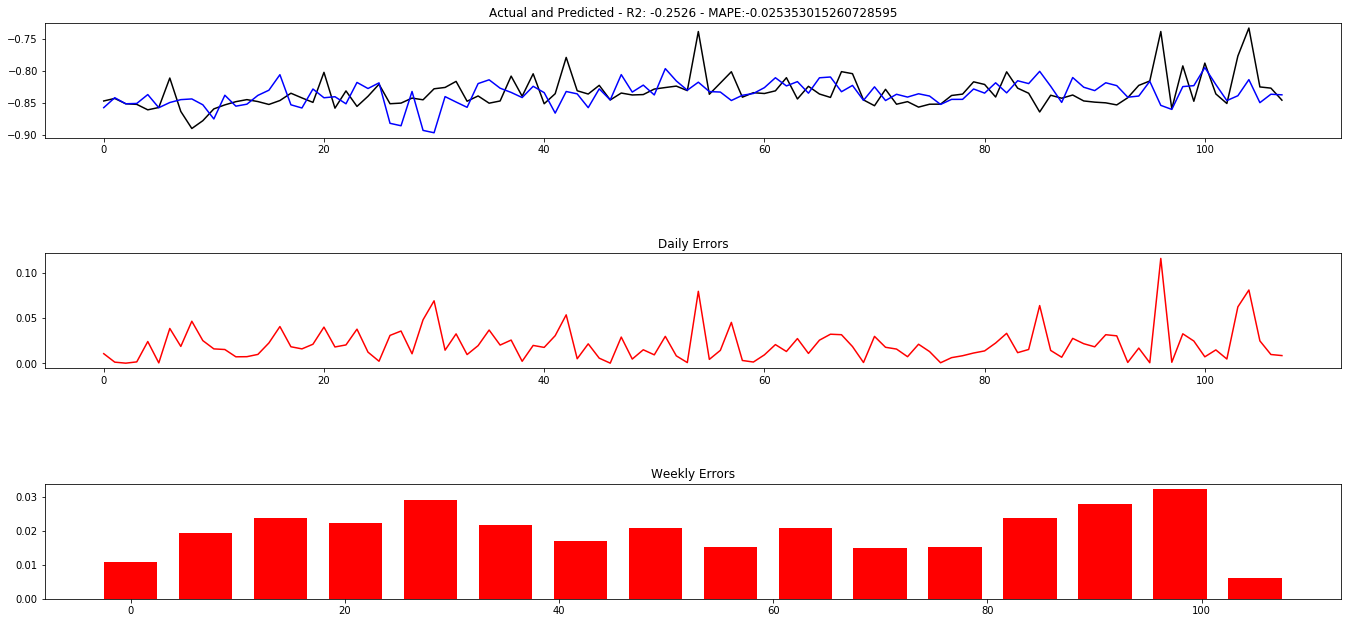

In [24]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [25]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [26]:
#normalized d_list
d_list = [test_daily_prices, test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


# Normalized

In [27]:
#normalized d_list
d_list = [norm_test_daily_prices, norm_test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


In [28]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

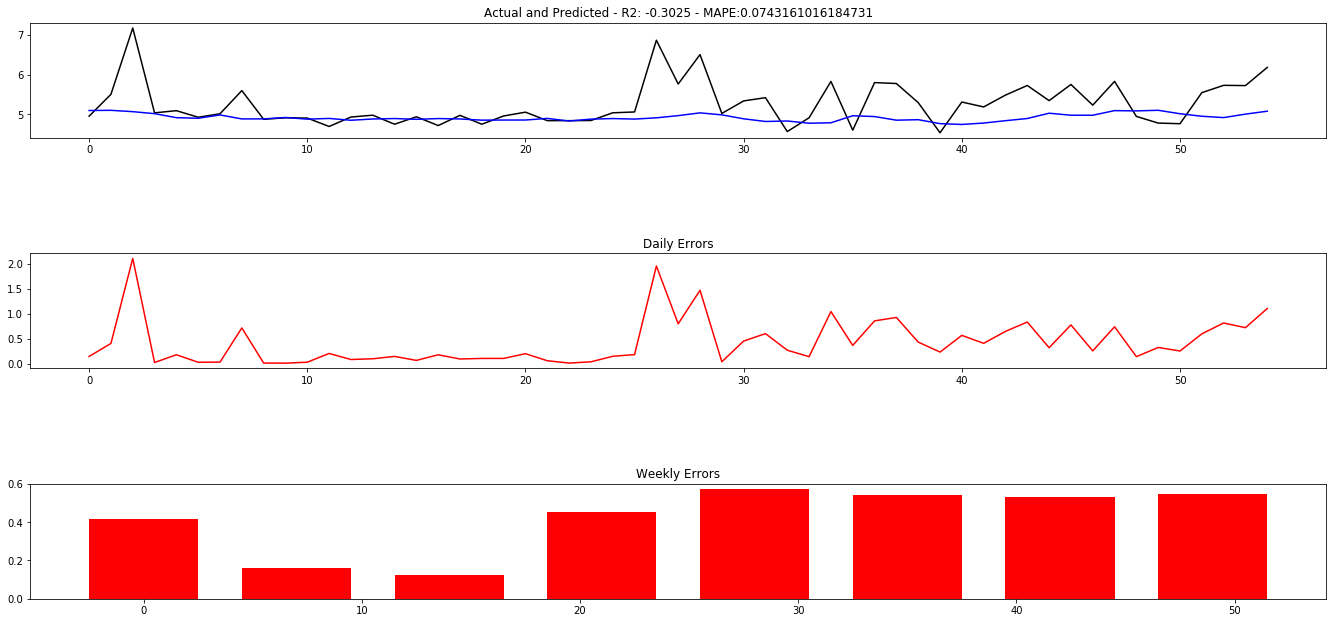

In [29]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

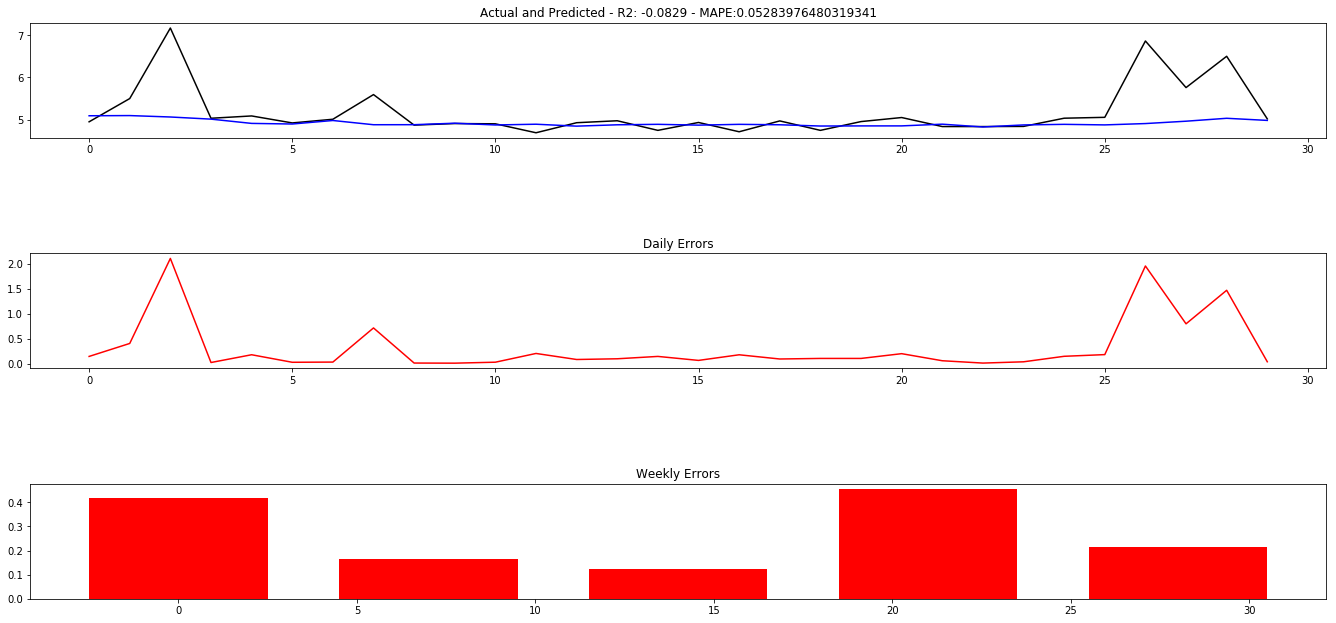

In [30]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [31]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [32]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (432, 6, 2)
X_val_: (108, 6, 2)


In [33]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[3.44864252e+00 1.42727800e+05]
 [4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]]
4.8021150000000015
**************************************************
[[4.18564490e+00 3.43000000e+04]
 [4.05010000e+00 1.60000000e+04]
 [3.48854046e+00 9.21372000e+04]
 [3.20351626e+00 9.10000000e+04]
 [3.46203679e+00 6.85000000e+04]
 [4.80211500e+00 1.40000000e+04]]
3.6562976577657653
**************************************************


In [34]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_paracetamol_price_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5


In [35]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 432 samples, validate on 108 samples
Epoch 1/1000
416/432 [===========================>..] - ETA: 0s - loss: 24.3945 - mean_absolute_error: 4.3097 - mean_squared_error: 24.3945 - mean_absolute_percentage_error: 100.2938
Epoch 00001: val_loss improved from inf to 31.38849, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 3s 6ms/step - loss: 24.1889 - mean_absolute_error: 4.3031 - mean_squared_error: 24.1889 - mean_absolute_percentage_error: 100.3180 - val_loss: 31.3885 - val_mean_absolute_error: 5.5692 - val_mean_squared_error: 31.3885 - val_mean_absolute_percentage_error: 100.6332
Epoch 2/1000
416/432 [===========================>..] - ETA: 0s - loss: 24.1386 - mean_absolute_error: 4.2913 - mean_squared_error: 24.1386 - mean_absolute_percentage_error: 100.2623
Epoch 00002: val_loss improved from 31.38849 to 31.37287, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/43

Epoch 14/1000
384/432 [=========================>....] - ETA: 0s - loss: 24.8753 - mean_absolute_error: 4.3134 - mean_squared_error: 24.8753 - mean_absolute_percentage_error: 99.7882
Epoch 00014: val_loss improved from 31.20157 to 31.18601, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 875us/step - loss: 24.0294 - mean_absolute_error: 4.2846 - mean_squared_error: 24.0294 - mean_absolute_percentage_error: 99.8592 - val_loss: 31.1860 - val_mean_absolute_error: 5.5510 - val_mean_squared_error: 31.1860 - val_mean_absolute_percentage_error: 100.3007
Epoch 15/1000
384/432 [=========================>....] - ETA: 0s - loss: 24.6379 - mean_absolute_error: 4.3040 - mean_squared_error: 24.6379 - mean_absolute_percentage_error: 99.9894
Epoch 00015: val_loss improved from 31.18601 to 31.17057, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 

Epoch 27/1000
384/432 [=========================>....] - ETA: 0s - loss: 24.7884 - mean_absolute_error: 4.3013 - mean_squared_error: 24.7884 - mean_absolute_percentage_error: 99.5674
Epoch 00027: val_loss improved from 31.00122 to 30.98570, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 23.8722 - mean_absolute_error: 4.2662 - mean_squared_error: 23.8722 - mean_absolute_percentage_error: 99.4038 - val_loss: 30.9857 - val_mean_absolute_error: 5.5329 - val_mean_squared_error: 30.9857 - val_mean_absolute_percentage_error: 99.9706
Epoch 28/1000
416/432 [===========================>..] - ETA: 0s - loss: 24.1672 - mean_absolute_error: 4.2769 - mean_squared_error: 24.1672 - mean_absolute_percentage_error: 99.3481
Epoch 00028: val_loss improved from 30.98570 to 30.97045, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2ms

Epoch 40/1000
416/432 [===========================>..] - ETA: 0s - loss: 24.0382 - mean_absolute_error: 4.2626 - mean_squared_error: 24.0382 - mean_absolute_percentage_error: 98.9298
Epoch 00040: val_loss improved from 30.80151 to 30.78625, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 23.7162 - mean_absolute_error: 4.2478 - mean_squared_error: 23.7162 - mean_absolute_percentage_error: 98.9503 - val_loss: 30.7863 - val_mean_absolute_error: 5.5149 - val_mean_squared_error: 30.7863 - val_mean_absolute_percentage_error: 99.6410
Epoch 41/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.8989 - mean_absolute_error: 4.2466 - mean_squared_error: 23.8989 - mean_absolute_percentage_error: 98.8939
Epoch 00041: val_loss improved from 30.78625 to 30.77106, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 8

416/432 [===========================>..] - ETA: 0s - loss: 23.7413 - mean_absolute_error: 4.2269 - mean_squared_error: 23.7413 - mean_absolute_percentage_error: 98.4742
Epoch 00053: val_loss improved from 30.60316 to 30.58814, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 827us/step - loss: 23.5615 - mean_absolute_error: 4.2296 - mean_squared_error: 23.5615 - mean_absolute_percentage_error: 98.4980 - val_loss: 30.5881 - val_mean_absolute_error: 5.4969 - val_mean_squared_error: 30.5881 - val_mean_absolute_percentage_error: 99.3125
Epoch 54/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.7500 - mean_absolute_error: 4.2272 - mean_squared_error: 23.7500 - mean_absolute_percentage_error: 98.4399
Epoch 00054: val_loss improved from 30.58814 to 30.57286, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 826us/step - lo

416/432 [===========================>..] - ETA: 0s - loss: 23.4618 - mean_absolute_error: 4.2001 - mean_squared_error: 23.4618 - mean_absolute_percentage_error: 98.0213
Epoch 00066: val_loss improved from 30.40581 to 30.39069, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 834us/step - loss: 23.4080 - mean_absolute_error: 4.2113 - mean_squared_error: 23.4080 - mean_absolute_percentage_error: 98.0466 - val_loss: 30.3907 - val_mean_absolute_error: 5.4789 - val_mean_squared_error: 30.3907 - val_mean_absolute_percentage_error: 98.9840
Epoch 67/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.6189 - mean_absolute_error: 4.2120 - mean_squared_error: 23.6189 - mean_absolute_percentage_error: 97.9887
Epoch 00067: val_loss improved from 30.39069 to 30.37561, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 845us/step - lo

416/432 [===========================>..] - ETA: 0s - loss: 23.4603 - mean_absolute_error: 4.1944 - mean_squared_error: 23.4603 - mean_absolute_percentage_error: 97.5737
Epoch 00079: val_loss improved from 30.20961 to 30.19457, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 829us/step - loss: 23.2559 - mean_absolute_error: 4.1931 - mean_squared_error: 23.2559 - mean_absolute_percentage_error: 97.5972 - val_loss: 30.1946 - val_mean_absolute_error: 5.4610 - val_mean_squared_error: 30.1946 - val_mean_absolute_percentage_error: 98.6566
Epoch 80/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.4949 - mean_absolute_error: 4.2009 - mean_squared_error: 23.4949 - mean_absolute_percentage_error: 97.7327
Epoch 00080: val_loss improved from 30.19457 to 30.17963, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 836us/step - lo

416/432 [===========================>..] - ETA: 0s - loss: 23.3136 - mean_absolute_error: 4.1771 - mean_squared_error: 23.3136 - mean_absolute_percentage_error: 97.1267
Epoch 00092: val_loss improved from 30.01421 to 29.99936, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 860us/step - loss: 23.1047 - mean_absolute_error: 4.1750 - mean_squared_error: 23.1047 - mean_absolute_percentage_error: 97.1501 - val_loss: 29.9994 - val_mean_absolute_error: 5.4431 - val_mean_squared_error: 29.9994 - val_mean_absolute_percentage_error: 98.3297
Epoch 93/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.3166 - mean_absolute_error: 4.1772 - mean_squared_error: 23.3166 - mean_absolute_percentage_error: 97.0930
Epoch 00093: val_loss improved from 29.99936 to 29.98421, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 827us/step - lo

Epoch 105/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.2064 - mean_absolute_error: 4.1634 - mean_squared_error: 23.2064 - mean_absolute_percentage_error: 96.6800
Epoch 00105: val_loss improved from 29.81986 to 29.80486, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 830us/step - loss: 22.9544 - mean_absolute_error: 4.1568 - mean_squared_error: 22.9544 - mean_absolute_percentage_error: 96.7010 - val_loss: 29.8049 - val_mean_absolute_error: 5.4252 - val_mean_squared_error: 29.8049 - val_mean_absolute_percentage_error: 98.0029
Epoch 106/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.1966 - mean_absolute_error: 4.1619 - mean_squared_error: 23.1966 - mean_absolute_percentage_error: 96.6451
Epoch 00106: val_loss improved from 29.80486 to 29.78996, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 118/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.1641 - mean_absolute_error: 4.1596 - mean_squared_error: 23.1641 - mean_absolute_percentage_error: 96.2503
Epoch 00118: val_loss improved from 29.62627 to 29.61143, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 22.8049 - mean_absolute_error: 4.1387 - mean_squared_error: 22.8049 - mean_absolute_percentage_error: 96.2539 - val_loss: 29.6114 - val_mean_absolute_error: 5.4073 - val_mean_squared_error: 29.6114 - val_mean_absolute_percentage_error: 97.6768
Epoch 119/1000
416/432 [===========================>..] - ETA: 0s - loss: 23.0521 - mean_absolute_error: 4.1487 - mean_squared_error: 23.0521 - mean_absolute_percentage_error: 96.3911
Epoch 00119: val_loss improved from 29.61143 to 29.59675, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 131/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.9662 - mean_absolute_error: 4.1336 - mean_squared_error: 22.9662 - mean_absolute_percentage_error: 95.7905
Epoch 00131: val_loss improved from 29.43338 to 29.41855, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 839us/step - loss: 22.6562 - mean_absolute_error: 4.1206 - mean_squared_error: 22.6562 - mean_absolute_percentage_error: 95.8071 - val_loss: 29.4185 - val_mean_absolute_error: 5.3895 - val_mean_squared_error: 29.4185 - val_mean_absolute_percentage_error: 97.3506
Epoch 132/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.8832 - mean_absolute_error: 4.1235 - mean_squared_error: 22.8832 - mean_absolute_percentage_error: 95.7484
Epoch 00132: val_loss improved from 29.41855 to 29.40369, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 144/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.7281 - mean_absolute_error: 4.1055 - mean_squared_error: 22.7281 - mean_absolute_percentage_error: 95.3374
Epoch 00144: val_loss improved from 29.24148 to 29.22669, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 808us/step - loss: 22.5087 - mean_absolute_error: 4.1026 - mean_squared_error: 22.5087 - mean_absolute_percentage_error: 95.3622 - val_loss: 29.2267 - val_mean_absolute_error: 5.3716 - val_mean_squared_error: 29.2267 - val_mean_absolute_percentage_error: 97.0250
Epoch 145/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.7237 - mean_absolute_error: 4.1038 - mean_squared_error: 22.7237 - mean_absolute_percentage_error: 95.3018
Epoch 00145: val_loss improved from 29.22669 to 29.21201, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 157/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.6074 - mean_absolute_error: 3.9727 - mean_squared_error: 16.6074 - mean_absolute_percentage_error: 94.8786
Epoch 00157: val_loss improved from 29.05026 to 29.03581, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 837us/step - loss: 22.3617 - mean_absolute_error: 4.0846 - mean_squared_error: 22.3617 - mean_absolute_percentage_error: 94.9178 - val_loss: 29.0358 - val_mean_absolute_error: 5.3538 - val_mean_squared_error: 29.0358 - val_mean_absolute_percentage_error: 96.7000
Epoch 158/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.6223 - mean_absolute_error: 4.0925 - mean_squared_error: 22.6223 - mean_absolute_percentage_error: 94.8660
Epoch 00158: val_loss improved from 29.03581 to 29.02080, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 170/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.4343 - mean_absolute_error: 4.0677 - mean_squared_error: 22.4343 - mean_absolute_percentage_error: 94.4444
Epoch 00170: val_loss improved from 28.85998 to 28.84544, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 839us/step - loss: 22.2160 - mean_absolute_error: 4.0666 - mean_squared_error: 22.2160 - mean_absolute_percentage_error: 94.4745 - val_loss: 28.8454 - val_mean_absolute_error: 5.3360 - val_mean_squared_error: 28.8454 - val_mean_absolute_percentage_error: 96.3748
Epoch 171/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.4665 - mean_absolute_error: 4.0730 - mean_squared_error: 22.4665 - mean_absolute_percentage_error: 94.4985
Epoch 00171: val_loss improved from 28.84544 to 28.83087, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 183/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.1650 - mean_absolute_error: 4.0379 - mean_squared_error: 22.1650 - mean_absolute_percentage_error: 93.9920
Epoch 00183: val_loss improved from 28.67075 to 28.65624, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 826us/step - loss: 22.0710 - mean_absolute_error: 4.0487 - mean_squared_error: 22.0710 - mean_absolute_percentage_error: 94.0310 - val_loss: 28.6562 - val_mean_absolute_error: 5.3183 - val_mean_squared_error: 28.6562 - val_mean_absolute_percentage_error: 96.0505
Epoch 184/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.3300 - mean_absolute_error: 4.0559 - mean_squared_error: 22.3300 - mean_absolute_percentage_error: 93.9791
Epoch 00184: val_loss improved from 28.65624 to 28.64156, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 196/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.1529 - mean_absolute_error: 4.0341 - mean_squared_error: 22.1529 - mean_absolute_percentage_error: 93.5642
Epoch 00196: val_loss improved from 28.48191 to 28.46754, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 896us/step - loss: 21.9266 - mean_absolute_error: 4.0308 - mean_squared_error: 21.9266 - mean_absolute_percentage_error: 93.5889 - val_loss: 28.4675 - val_mean_absolute_error: 5.3005 - val_mean_squared_error: 28.4675 - val_mean_absolute_percentage_error: 95.7260
Epoch 197/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.0900 - mean_absolute_error: 4.0268 - mean_squared_error: 22.0900 - mean_absolute_percentage_error: 93.5219
Epoch 00197: val_loss improved from 28.46754 to 28.45310, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 209/1000
416/432 [===========================>..] - ETA: 0s - loss: 22.0886 - mean_absolute_error: 4.0252 - mean_squared_error: 22.0886 - mean_absolute_percentage_error: 93.1315
Epoch 00209: val_loss improved from 28.29411 to 28.27964, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 837us/step - loss: 21.7833 - mean_absolute_error: 4.0128 - mean_squared_error: 21.7833 - mean_absolute_percentage_error: 93.1464 - val_loss: 28.2796 - val_mean_absolute_error: 5.2827 - val_mean_squared_error: 28.2796 - val_mean_absolute_percentage_error: 95.4018
Epoch 210/1000
352/432 [=======================>......] - ETA: 0s - loss: 22.7797 - mean_absolute_error: 4.0176 - mean_squared_error: 22.7797 - mean_absolute_percentage_error: 93.1034
Epoch 00210: val_loss improved from 28.27964 to 28.26518, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 222/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.8876 - mean_absolute_error: 4.0034 - mean_squared_error: 21.8876 - mean_absolute_percentage_error: 92.7809
Epoch 00222: val_loss improved from 28.10686 to 28.09245, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 841us/step - loss: 21.6405 - mean_absolute_error: 3.9949 - mean_squared_error: 21.6405 - mean_absolute_percentage_error: 92.7038 - val_loss: 28.0925 - val_mean_absolute_error: 5.2650 - val_mean_squared_error: 28.0925 - val_mean_absolute_percentage_error: 95.0777
Epoch 223/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.8185 - mean_absolute_error: 3.9966 - mean_squared_error: 21.8185 - mean_absolute_percentage_error: 92.6511
Epoch 00223: val_loss improved from 28.09245 to 28.07817, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 235/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.7347 - mean_absolute_error: 3.9806 - mean_squared_error: 21.7347 - mean_absolute_percentage_error: 92.2342
Epoch 00235: val_loss improved from 27.92060 to 27.90636, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 820us/step - loss: 21.4985 - mean_absolute_error: 3.9771 - mean_squared_error: 21.4985 - mean_absolute_percentage_error: 92.2632 - val_loss: 27.9064 - val_mean_absolute_error: 5.2473 - val_mean_squared_error: 27.9064 - val_mean_absolute_percentage_error: 94.7545
Epoch 236/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.8080 - mean_absolute_error: 3.9902 - mean_squared_error: 21.8080 - mean_absolute_percentage_error: 92.2197
Epoch 00236: val_loss improved from 27.90636 to 27.89193, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 248/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.6350 - mean_absolute_error: 3.9682 - mean_squared_error: 21.6350 - mean_absolute_percentage_error: 91.8037 ETA: 0s - loss: 15.9527 - mean_absolute_error: 3.8385 - mean_squared_error: 15.9527 - mean_absolute_percentage_error: 9
Epoch 00248: val_loss improved from 27.73500 to 27.72079, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 833us/step - loss: 21.3574 - mean_absolute_error: 3.9592 - mean_squared_error: 21.3574 - mean_absolute_percentage_error: 91.8227 - val_loss: 27.7208 - val_mean_absolute_error: 5.2296 - val_mean_squared_error: 27.7208 - val_mean_absolute_percentage_error: 94.4310
Epoch 249/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.4657 - mean_absolute_error: 3.9516 - mean_squared_error: 21.4657 - mean_absolute_percentage_error: 91.7511
Epoch 00249: val_loss improved from 27.72079 to 27.70647, saving

Epoch 261/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.5885 - mean_absolute_error: 3.8452 - mean_squared_error: 15.5885 - mean_absolute_percentage_error: 91.5506
Epoch 00261: val_loss improved from 27.55000 to 27.53601, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 843us/step - loss: 21.2169 - mean_absolute_error: 3.9414 - mean_squared_error: 21.2169 - mean_absolute_percentage_error: 91.3827 - val_loss: 27.5360 - val_mean_absolute_error: 5.2119 - val_mean_squared_error: 27.5360 - val_mean_absolute_percentage_error: 94.1079
Epoch 262/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.5113 - mean_absolute_error: 3.9535 - mean_squared_error: 21.5113 - mean_absolute_percentage_error: 91.3423
Epoch 00262: val_loss improved from 27.53601 to 27.52154, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 274/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.4339 - mean_absolute_error: 3.8216 - mean_squared_error: 15.4339 - mean_absolute_percentage_error: 90.9777
Epoch 00274: val_loss improved from 27.36572 to 27.35170, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 842us/step - loss: 21.0772 - mean_absolute_error: 3.9235 - mean_squared_error: 21.0772 - mean_absolute_percentage_error: 90.9429 - val_loss: 27.3517 - val_mean_absolute_error: 5.1942 - val_mean_squared_error: 27.3517 - val_mean_absolute_percentage_error: 93.7844
Epoch 275/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.0456 - mean_absolute_error: 3.9141 - mean_squared_error: 21.0456 - mean_absolute_percentage_error: 90.8857
Epoch 00275: val_loss improved from 27.35170 to 27.33718, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 287/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.2062 - mean_absolute_error: 3.9163 - mean_squared_error: 21.2062 - mean_absolute_percentage_error: 90.5122
Epoch 00287: val_loss improved from 27.18201 to 27.16750, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 847us/step - loss: 20.9379 - mean_absolute_error: 3.9057 - mean_squared_error: 20.9379 - mean_absolute_percentage_error: 90.5014 - val_loss: 27.1675 - val_mean_absolute_error: 5.1764 - val_mean_squared_error: 27.1675 - val_mean_absolute_percentage_error: 93.4601
Epoch 288/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.0773 - mean_absolute_error: 3.8999 - mean_squared_error: 21.0773 - mean_absolute_percentage_error: 90.4281
Epoch 00288: val_loss improved from 27.16750 to 27.15348, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 300/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.8912 - mean_absolute_error: 3.8757 - mean_squared_error: 20.8912 - mean_absolute_percentage_error: 90.0055
Epoch 00300: val_loss improved from 26.99879 to 26.98465, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 838us/step - loss: 20.7995 - mean_absolute_error: 3.8878 - mean_squared_error: 20.7995 - mean_absolute_percentage_error: 90.0614 - val_loss: 26.9847 - val_mean_absolute_error: 5.1587 - val_mean_squared_error: 26.9847 - val_mean_absolute_percentage_error: 93.1370
Epoch 301/1000
416/432 [===========================>..] - ETA: 0s - loss: 21.0359 - mean_absolute_error: 3.8918 - mean_squared_error: 21.0359 - mean_absolute_percentage_error: 90.0019
Epoch 00301: val_loss improved from 26.98465 to 26.97066, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 313/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.8832 - mean_absolute_error: 3.8730 - mean_squared_error: 20.8832 - mean_absolute_percentage_error: 89.6652
Epoch 00313: val_loss improved from 26.81635 to 26.80231, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 840us/step - loss: 20.6617 - mean_absolute_error: 3.8700 - mean_squared_error: 20.6617 - mean_absolute_percentage_error: 89.6214 - val_loss: 26.8023 - val_mean_absolute_error: 5.1410 - val_mean_squared_error: 26.8023 - val_mean_absolute_percentage_error: 92.8137
Epoch 314/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.7545 - mean_absolute_error: 3.8663 - mean_squared_error: 20.7545 - mean_absolute_percentage_error: 89.5689
Epoch 00314: val_loss improved from 26.80231 to 26.78859, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 326/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.6814 - mean_absolute_error: 3.8466 - mean_squared_error: 20.6814 - mean_absolute_percentage_error: 89.1347
Epoch 00326: val_loss improved from 26.63519 to 26.62131, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 830us/step - loss: 20.5248 - mean_absolute_error: 3.8523 - mean_squared_error: 20.5248 - mean_absolute_percentage_error: 89.1840 - val_loss: 26.6213 - val_mean_absolute_error: 5.1234 - val_mean_squared_error: 26.6213 - val_mean_absolute_percentage_error: 92.4917
Epoch 327/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.6707 - mean_absolute_error: 3.8451 - mean_squared_error: 20.6707 - mean_absolute_percentage_error: 89.1011
Epoch 00327: val_loss improved from 26.62131 to 26.60726, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 339/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.5885 - mean_absolute_error: 3.8332 - mean_squared_error: 20.5885 - mean_absolute_percentage_error: 88.7008
Epoch 00339: val_loss improved from 26.45431 to 26.44044, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 829us/step - loss: 20.3887 - mean_absolute_error: 3.8345 - mean_squared_error: 20.3887 - mean_absolute_percentage_error: 88.7451 - val_loss: 26.4404 - val_mean_absolute_error: 5.1057 - val_mean_squared_error: 26.4404 - val_mean_absolute_percentage_error: 92.1688
Epoch 340/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.5534 - mean_absolute_error: 3.8320 - mean_squared_error: 20.5534 - mean_absolute_percentage_error: 88.7000
Epoch 00340: val_loss improved from 26.44044 to 26.42653, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 352/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.4258 - mean_absolute_error: 3.8131 - mean_squared_error: 20.4258 - mean_absolute_percentage_error: 88.2618
Epoch 00352: val_loss improved from 26.27451 to 26.26033, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 20.2532 - mean_absolute_error: 3.8167 - mean_squared_error: 20.2532 - mean_absolute_percentage_error: 88.3069 - val_loss: 26.2603 - val_mean_absolute_error: 5.0880 - val_mean_squared_error: 26.2603 - val_mean_absolute_percentage_error: 91.8462
Epoch 353/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.4253 - mean_absolute_error: 3.8131 - mean_squared_error: 20.4253 - mean_absolute_percentage_error: 88.2291
Epoch 00353: val_loss improved from 26.26033 to 26.24635, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 365/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.3300 - mean_absolute_error: 3.7993 - mean_squared_error: 20.3300 - mean_absolute_percentage_error: 87.8258
Epoch 00365: val_loss improved from 26.09470 to 26.08081, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 839us/step - loss: 20.1183 - mean_absolute_error: 3.7989 - mean_squared_error: 20.1183 - mean_absolute_percentage_error: 87.8676 - val_loss: 26.0808 - val_mean_absolute_error: 5.0704 - val_mean_squared_error: 26.0808 - val_mean_absolute_percentage_error: 91.5235
Epoch 366/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.3276 - mean_absolute_error: 3.8000 - mean_squared_error: 20.3276 - mean_absolute_percentage_error: 87.8021
Epoch 00366: val_loss improved from 26.08081 to 26.06704, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 378/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.2569 - mean_absolute_error: 3.7906 - mean_squared_error: 20.2569 - mean_absolute_percentage_error: 87.4184
Epoch 00378: val_loss improved from 25.91602 to 25.90213, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 847us/step - loss: 19.9841 - mean_absolute_error: 3.7812 - mean_squared_error: 19.9841 - mean_absolute_percentage_error: 87.4302 - val_loss: 25.9021 - val_mean_absolute_error: 5.0527 - val_mean_squared_error: 25.9021 - val_mean_absolute_percentage_error: 91.2012
Epoch 379/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.0721 - mean_absolute_error: 3.7743 - mean_squared_error: 20.0721 - mean_absolute_percentage_error: 87.4690
Epoch 00379: val_loss improved from 25.90213 to 25.88829, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 391/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.0857 - mean_absolute_error: 3.7727 - mean_squared_error: 20.0857 - mean_absolute_percentage_error: 87.1632
Epoch 00391: val_loss improved from 25.73783 to 25.72418, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 840us/step - loss: 19.8507 - mean_absolute_error: 3.7635 - mean_squared_error: 19.8507 - mean_absolute_percentage_error: 86.9923 - val_loss: 25.7242 - val_mean_absolute_error: 5.0351 - val_mean_squared_error: 25.7242 - val_mean_absolute_percentage_error: 90.8790
Epoch 392/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.0842 - mean_absolute_error: 3.7681 - mean_squared_error: 20.0842 - mean_absolute_percentage_error: 86.9391
Epoch 00392: val_loss improved from 25.72418 to 25.71057, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 404/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.9370 - mean_absolute_error: 3.7508 - mean_squared_error: 19.9370 - mean_absolute_percentage_error: 86.6449
Epoch 00404: val_loss improved from 25.56061 to 25.54702, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 837us/step - loss: 19.7179 - mean_absolute_error: 3.7457 - mean_squared_error: 19.7179 - mean_absolute_percentage_error: 86.5544 - val_loss: 25.5470 - val_mean_absolute_error: 5.0174 - val_mean_squared_error: 25.5470 - val_mean_absolute_percentage_error: 90.5572
Epoch 405/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.9399 - mean_absolute_error: 3.7569 - mean_squared_error: 19.9399 - mean_absolute_percentage_error: 86.6522
Epoch 00405: val_loss improved from 25.54702 to 25.53332, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 417/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.7862 - mean_absolute_error: 3.7265 - mean_squared_error: 19.7862 - mean_absolute_percentage_error: 86.0660
Epoch 00417: val_loss improved from 25.38390 to 25.37025, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 820us/step - loss: 19.5859 - mean_absolute_error: 3.7280 - mean_squared_error: 19.5859 - mean_absolute_percentage_error: 86.1171 - val_loss: 25.3702 - val_mean_absolute_error: 4.9998 - val_mean_squared_error: 25.3702 - val_mean_absolute_percentage_error: 90.2350
Epoch 418/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.7354 - mean_absolute_error: 3.7220 - mean_squared_error: 19.7354 - mean_absolute_percentage_error: 86.0321
Epoch 00418: val_loss improved from 25.37025 to 25.35677, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 430/1000
384/432 [=========================>....] - ETA: 0s - loss: 20.2184 - mean_absolute_error: 3.7322 - mean_squared_error: 20.2184 - mean_absolute_percentage_error: 85.7561
Epoch 00430: val_loss improved from 25.20775 to 25.19414, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 19.4544 - mean_absolute_error: 3.7103 - mean_squared_error: 19.4544 - mean_absolute_percentage_error: 85.6803 - val_loss: 25.1941 - val_mean_absolute_error: 4.9821 - val_mean_squared_error: 25.1941 - val_mean_absolute_percentage_error: 89.9128
Epoch 431/1000
384/432 [=========================>....] - ETA: 0s - loss: 19.9567 - mean_absolute_error: 3.7157 - mean_squared_error: 19.9567 - mean_absolute_percentage_error: 85.7096
Epoch 00431: val_loss improved from 25.19414 to 25.18079, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2

Epoch 443/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.6258 - mean_absolute_error: 3.7065 - mean_squared_error: 19.6258 - mean_absolute_percentage_error: 85.2520
Epoch 00443: val_loss improved from 25.03247 to 25.01898, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 844us/step - loss: 19.3237 - mean_absolute_error: 3.6926 - mean_squared_error: 19.3237 - mean_absolute_percentage_error: 85.2440 - val_loss: 25.0190 - val_mean_absolute_error: 4.9645 - val_mean_squared_error: 25.0190 - val_mean_absolute_percentage_error: 89.5912
Epoch 444/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.5529 - mean_absolute_error: 3.6972 - mean_squared_error: 19.5529 - mean_absolute_percentage_error: 85.1936
Epoch 00444: val_loss improved from 25.01898 to 25.00560, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 456/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.4331 - mean_absolute_error: 3.6799 - mean_squared_error: 19.4331 - mean_absolute_percentage_error: 84.7820
Epoch 00456: val_loss improved from 24.85757 to 24.84421, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 863us/step - loss: 19.1933 - mean_absolute_error: 3.6749 - mean_squared_error: 19.1933 - mean_absolute_percentage_error: 84.8078 - val_loss: 24.8442 - val_mean_absolute_error: 4.9469 - val_mean_squared_error: 24.8442 - val_mean_absolute_percentage_error: 89.2692
Epoch 457/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.3784 - mean_absolute_error: 3.6737 - mean_squared_error: 19.3784 - mean_absolute_percentage_error: 84.7387
Epoch 00457: val_loss improved from 24.84421 to 24.83062, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 469/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.3224 - mean_absolute_error: 3.6654 - mean_squared_error: 19.3224 - mean_absolute_percentage_error: 84.3604
Epoch 00469: val_loss improved from 24.68322 to 24.66994, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 1ms/step - loss: 19.0638 - mean_absolute_error: 3.6572 - mean_squared_error: 19.0638 - mean_absolute_percentage_error: 84.3704 - val_loss: 24.6699 - val_mean_absolute_error: 4.9293 - val_mean_squared_error: 24.6699 - val_mean_absolute_percentage_error: 88.9470
Epoch 470/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.2633 - mean_absolute_error: 3.6568 - mean_squared_error: 19.2633 - mean_absolute_percentage_error: 84.2974
Epoch 00470: val_loss improved from 24.66994 to 24.65662, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 1

Epoch 482/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.2300 - mean_absolute_error: 3.6514 - mean_squared_error: 19.2300 - mean_absolute_percentage_error: 83.9289
Epoch 00482: val_loss improved from 24.50948 to 24.49607, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 814us/step - loss: 18.9349 - mean_absolute_error: 3.6395 - mean_squared_error: 18.9349 - mean_absolute_percentage_error: 83.9339 - val_loss: 24.4961 - val_mean_absolute_error: 4.9116 - val_mean_squared_error: 24.4961 - val_mean_absolute_percentage_error: 88.6244
Epoch 483/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.1530 - mean_absolute_error: 3.6435 - mean_squared_error: 19.1530 - mean_absolute_percentage_error: 83.8846
Epoch 00483: val_loss improved from 24.49607 to 24.48287, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 495/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.0675 - mean_absolute_error: 3.6318 - mean_squared_error: 19.0675 - mean_absolute_percentage_error: 83.5772
Epoch 00495: val_loss improved from 24.33651 to 24.32313, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 1ms/step - loss: 18.8066 - mean_absolute_error: 3.6219 - mean_squared_error: 18.8066 - mean_absolute_percentage_error: 83.4981 - val_loss: 24.3231 - val_mean_absolute_error: 4.8940 - val_mean_squared_error: 24.3231 - val_mean_absolute_percentage_error: 88.3023
Epoch 496/1000
416/432 [===========================>..] - ETA: 0s - loss: 19.0935 - mean_absolute_error: 3.6333 - mean_squared_error: 19.0935 - mean_absolute_percentage_error: 83.4676
Epoch 00496: val_loss improved from 24.32313 to 24.30988, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2

Epoch 508/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.9598 - mean_absolute_error: 3.6157 - mean_squared_error: 18.9598 - mean_absolute_percentage_error: 83.1414
Epoch 00508: val_loss improved from 24.16453 to 24.15135, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 851us/step - loss: 18.6793 - mean_absolute_error: 3.6043 - mean_squared_error: 18.6793 - mean_absolute_percentage_error: 83.0645 - val_loss: 24.1513 - val_mean_absolute_error: 4.8764 - val_mean_squared_error: 24.1513 - val_mean_absolute_percentage_error: 87.9812
Epoch 509/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.8787 - mean_absolute_error: 3.6050 - mean_squared_error: 18.8787 - mean_absolute_percentage_error: 83.0004
Epoch 00509: val_loss improved from 24.15135 to 24.13822, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 521/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.8219 - mean_absolute_error: 3.5948 - mean_squared_error: 18.8219 - mean_absolute_percentage_error: 82.6094
Epoch 00521: val_loss improved from 23.99336 to 23.98005, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 842us/step - loss: 18.5527 - mean_absolute_error: 3.5867 - mean_squared_error: 18.5527 - mean_absolute_percentage_error: 82.6305 - val_loss: 23.9800 - val_mean_absolute_error: 4.8588 - val_mean_squared_error: 23.9800 - val_mean_absolute_percentage_error: 87.6599
Epoch 522/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.8017 - mean_absolute_error: 3.5928 - mean_squared_error: 18.8017 - mean_absolute_percentage_error: 82.5802
Epoch 00522: val_loss improved from 23.98005 to 23.96709, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 534/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.7780 - mean_absolute_error: 3.5946 - mean_squared_error: 18.7780 - mean_absolute_percentage_error: 82.4842
Epoch 00534: val_loss improved from 23.82265 to 23.80945, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 860us/step - loss: 18.4265 - mean_absolute_error: 3.5692 - mean_squared_error: 18.4265 - mean_absolute_percentage_error: 82.1971 - val_loss: 23.8095 - val_mean_absolute_error: 4.8412 - val_mean_squared_error: 23.8095 - val_mean_absolute_percentage_error: 87.3388
Epoch 535/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.6727 - mean_absolute_error: 3.5750 - mean_squared_error: 18.6727 - mean_absolute_percentage_error: 82.1459
Epoch 00535: val_loss improved from 23.80945 to 23.79638, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 547/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.5466 - mean_absolute_error: 3.5567 - mean_squared_error: 18.5466 - mean_absolute_percentage_error: 81.7320
Epoch 00547: val_loss improved from 23.65255 to 23.63945, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 18.3010 - mean_absolute_error: 3.5515 - mean_squared_error: 18.3010 - mean_absolute_percentage_error: 81.7615 - val_loss: 23.6394 - val_mean_absolute_error: 4.8236 - val_mean_squared_error: 23.6394 - val_mean_absolute_percentage_error: 87.0176
Epoch 548/1000
416/432 [===========================>..] - ETA: 0s - loss: 12.6388 - mean_absolute_error: 3.4369 - mean_squared_error: 12.6388 - mean_absolute_percentage_error: 81.6376
Epoch 00548: val_loss improved from 23.63945 to 23.62641, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 560/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.3776 - mean_absolute_error: 3.5334 - mean_squared_error: 18.3776 - mean_absolute_percentage_error: 81.2767
Epoch 00560: val_loss improved from 23.48240 to 23.46952, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 18.1758 - mean_absolute_error: 3.5339 - mean_squared_error: 18.1758 - mean_absolute_percentage_error: 81.3259 - val_loss: 23.4695 - val_mean_absolute_error: 4.8060 - val_mean_squared_error: 23.4695 - val_mean_absolute_percentage_error: 86.6953
Epoch 561/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.4260 - mean_absolute_error: 3.5399 - mean_squared_error: 18.4260 - mean_absolute_percentage_error: 81.2722
Epoch 00561: val_loss improved from 23.46952 to 23.45633, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 2

Epoch 573/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.3292 - mean_absolute_error: 3.5277 - mean_squared_error: 18.3292 - mean_absolute_percentage_error: 80.8970
Epoch 00573: val_loss improved from 23.31360 to 23.30066, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 848us/step - loss: 18.0517 - mean_absolute_error: 3.5163 - mean_squared_error: 18.0517 - mean_absolute_percentage_error: 80.8911 - val_loss: 23.3007 - val_mean_absolute_error: 4.7884 - val_mean_squared_error: 23.3007 - val_mean_absolute_percentage_error: 86.3739
Epoch 574/1000
416/432 [===========================>..] - ETA: 0s - loss: 20.1917 - mean_absolute_error: 3.5753 - mean_squared_error: 20.1917 - mean_absolute_percentage_error: 81.08 - ETA: 0s - loss: 18.2526 - mean_absolute_error: 3.5153 - mean_squared_error: 18.2526 - mean_absolute_percentage_error: 80.8081
Epoch 00574: val_loss improved from 23.30066 to 23.28770, 

Epoch 586/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.0593 - mean_absolute_error: 3.4916 - mean_squared_error: 18.0593 - mean_absolute_percentage_error: 80.3914
Epoch 00586: val_loss improved from 23.14524 to 23.13235, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 845us/step - loss: 17.9280 - mean_absolute_error: 3.4986 - mean_squared_error: 17.9280 - mean_absolute_percentage_error: 80.4558 - val_loss: 23.1323 - val_mean_absolute_error: 4.7707 - val_mean_squared_error: 23.1323 - val_mean_absolute_percentage_error: 86.0524
Epoch 587/1000
416/432 [===========================>..] - ETA: 0s - loss: 18.1691 - mean_absolute_error: 3.5037 - mean_squared_error: 18.1691 - mean_absolute_percentage_error: 80.4015
Epoch 00587: val_loss improved from 23.13235 to 23.11927, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 599/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.9731 - mean_absolute_error: 3.4769 - mean_squared_error: 17.9731 - mean_absolute_percentage_error: 79.9611
Epoch 00599: val_loss improved from 22.97721 to 22.96451, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 815us/step - loss: 17.8048 - mean_absolute_error: 3.4811 - mean_squared_error: 17.8048 - mean_absolute_percentage_error: 80.0225 - val_loss: 22.9645 - val_mean_absolute_error: 4.7531 - val_mean_squared_error: 22.9645 - val_mean_absolute_percentage_error: 85.7306
Epoch 600/1000
384/432 [=========================>....] - ETA: 0s - loss: 18.2830 - mean_absolute_error: 3.4674 - mean_squared_error: 18.2830 - mean_absolute_percentage_error: 79.9169
Epoch 00600: val_loss improved from 22.96451 to 22.95153, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 612/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.8235 - mean_absolute_error: 3.4601 - mean_squared_error: 17.8235 - mean_absolute_percentage_error: 79.5468
Epoch 00612: val_loss improved from 22.81057 to 22.79775, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 851us/step - loss: 17.6829 - mean_absolute_error: 3.4636 - mean_squared_error: 17.6829 - mean_absolute_percentage_error: 79.5907 - val_loss: 22.7978 - val_mean_absolute_error: 4.7355 - val_mean_squared_error: 22.7978 - val_mean_absolute_percentage_error: 85.4097
Epoch 613/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.9030 - mean_absolute_error: 3.4676 - mean_squared_error: 17.9030 - mean_absolute_percentage_error: 79.6193
Epoch 00613: val_loss improved from 22.79775 to 22.78489, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 625/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.7961 - mean_absolute_error: 3.4509 - mean_squared_error: 17.7961 - mean_absolute_percentage_error: 79.1346
Epoch 00625: val_loss improved from 22.64458 to 22.63176, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 856us/step - loss: 17.5614 - mean_absolute_error: 3.4461 - mean_squared_error: 17.5614 - mean_absolute_percentage_error: 79.1592 - val_loss: 22.6318 - val_mean_absolute_error: 4.7180 - val_mean_squared_error: 22.6318 - val_mean_absolute_percentage_error: 85.0890
Epoch 626/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.7632 - mean_absolute_error: 3.4450 - mean_squared_error: 17.7632 - mean_absolute_percentage_error: 79.0714
Epoch 00626: val_loss improved from 22.63176 to 22.61917, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 638/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.7070 - mean_absolute_error: 3.4370 - mean_squared_error: 17.7070 - mean_absolute_percentage_error: 78.7106
Epoch 00638: val_loss improved from 22.47873 to 22.46597, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 810us/step - loss: 17.4403 - mean_absolute_error: 3.4285 - mean_squared_error: 17.4403 - mean_absolute_percentage_error: 78.7231 - val_loss: 22.4660 - val_mean_absolute_error: 4.7004 - val_mean_squared_error: 22.4660 - val_mean_absolute_percentage_error: 84.7676
Epoch 639/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.6977 - mean_absolute_error: 3.4364 - mean_squared_error: 17.6977 - mean_absolute_percentage_error: 78.6869
Epoch 00639: val_loss improved from 22.46597 to 22.45336, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 651/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.6198 - mean_absolute_error: 3.4297 - mean_squared_error: 17.6198 - mean_absolute_percentage_error: 78.4984
Epoch 00651: val_loss improved from 22.31369 to 22.30087, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 835us/step - loss: 17.3200 - mean_absolute_error: 3.4108 - mean_squared_error: 17.3200 - mean_absolute_percentage_error: 78.2881 - val_loss: 22.3009 - val_mean_absolute_error: 4.6828 - val_mean_squared_error: 22.3009 - val_mean_absolute_percentage_error: 84.4463
Epoch 652/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.6020 - mean_absolute_error: 3.4215 - mean_squared_error: 17.6020 - mean_absolute_percentage_error: 78.2568
Epoch 00652: val_loss improved from 22.30087 to 22.28845, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 664/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.4191 - mean_absolute_error: 3.3978 - mean_squared_error: 17.4191 - mean_absolute_percentage_error: 77.8432
Epoch 00664: val_loss improved from 22.14961 to 22.13656, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 819us/step - loss: 17.2004 - mean_absolute_error: 3.3933 - mean_squared_error: 17.2004 - mean_absolute_percentage_error: 77.8544 - val_loss: 22.1366 - val_mean_absolute_error: 4.6652 - val_mean_squared_error: 22.1366 - val_mean_absolute_percentage_error: 84.1253
Epoch 665/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.1545 - mean_absolute_error: 3.3791 - mean_squared_error: 17.1545 - mean_absolute_percentage_error: 77.7675
Epoch 00665: val_loss improved from 22.13656 to 22.12396, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 677/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.3028 - mean_absolute_error: 3.3806 - mean_squared_error: 17.3028 - mean_absolute_percentage_error: 77.4060
Epoch 00677: val_loss improved from 21.98546 to 21.97294, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 1ms/step - loss: 17.0811 - mean_absolute_error: 3.3757 - mean_squared_error: 17.0811 - mean_absolute_percentage_error: 77.4210 - val_loss: 21.9729 - val_mean_absolute_error: 4.6476 - val_mean_squared_error: 21.9729 - val_mean_absolute_percentage_error: 83.8045
Epoch 678/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.3960 - mean_absolute_error: 3.3962 - mean_squared_error: 17.3960 - mean_absolute_percentage_error: 77.6477
Epoch 00678: val_loss improved from 21.97294 to 21.96027, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s 1

Epoch 690/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.2473 - mean_absolute_error: 3.3699 - mean_squared_error: 17.2473 - mean_absolute_percentage_error: 76.9976
Epoch 00690: val_loss improved from 21.82279 to 21.81046, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 832us/step - loss: 16.9630 - mean_absolute_error: 3.3583 - mean_squared_error: 16.9630 - mean_absolute_percentage_error: 76.9918 - val_loss: 21.8105 - val_mean_absolute_error: 4.6301 - val_mean_squared_error: 21.8105 - val_mean_absolute_percentage_error: 83.4847
Epoch 691/1000
416/432 [===========================>..] - ETA: 0s - loss: 11.3909 - mean_absolute_error: 3.2490 - mean_squared_error: 11.3909 - mean_absolute_percentage_error: 76.8735
Epoch 00691: val_loss improved from 21.81046 to 21.79799, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 703/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.0716 - mean_absolute_error: 3.3471 - mean_squared_error: 17.0716 - mean_absolute_percentage_error: 76.6556
Epoch 00703: val_loss improved from 21.66037 to 21.64801, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 840us/step - loss: 16.8452 - mean_absolute_error: 3.3407 - mean_squared_error: 16.8452 - mean_absolute_percentage_error: 76.5574 - val_loss: 21.6480 - val_mean_absolute_error: 4.6126 - val_mean_squared_error: 21.6480 - val_mean_absolute_percentage_error: 83.1637
Epoch 704/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.0492 - mean_absolute_error: 3.3400 - mean_squared_error: 17.0492 - mean_absolute_percentage_error: 76.4678
Epoch 00704: val_loss improved from 21.64801 to 21.63552, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 716/1000
416/432 [===========================>..] - ETA: 0s - loss: 17.0271 - mean_absolute_error: 3.3415 - mean_squared_error: 17.0271 - mean_absolute_percentage_error: 76.3196
Epoch 00716: val_loss improved from 21.49891 to 21.48648, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 16.7284 - mean_absolute_error: 3.3233 - mean_squared_error: 16.7284 - mean_absolute_percentage_error: 76.1279 - val_loss: 21.4865 - val_mean_absolute_error: 4.5950 - val_mean_squared_error: 21.4865 - val_mean_absolute_percentage_error: 82.8434
Epoch 717/1000
384/432 [=========================>....] - ETA: 0s - loss: 17.5219 - mean_absolute_error: 3.3472 - mean_squared_error: 17.5219 - mean_absolute_percentage_error: 76.1894
Epoch 00717: val_loss improved from 21.48648 to 21.47419, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 729/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.8212 - mean_absolute_error: 3.3117 - mean_squared_error: 16.8212 - mean_absolute_percentage_error: 75.8176
Epoch 00729: val_loss improved from 21.33760 to 21.32529, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 838us/step - loss: 16.6118 - mean_absolute_error: 3.3058 - mean_squared_error: 16.6118 - mean_absolute_percentage_error: 75.6944 - val_loss: 21.3253 - val_mean_absolute_error: 4.5774 - val_mean_squared_error: 21.3253 - val_mean_absolute_percentage_error: 82.5225
Epoch 730/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.7778 - mean_absolute_error: 3.3028 - mean_squared_error: 16.7778 - mean_absolute_percentage_error: 75.6195
Epoch 00730: val_loss improved from 21.32529 to 21.31295, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 742/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.7091 - mean_absolute_error: 3.2894 - mean_squared_error: 16.7091 - mean_absolute_percentage_error: 75.2110
Epoch 00742: val_loss improved from 21.17751 to 21.16522, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 824us/step - loss: 16.4963 - mean_absolute_error: 3.2882 - mean_squared_error: 16.4963 - mean_absolute_percentage_error: 75.2609 - val_loss: 21.1652 - val_mean_absolute_error: 4.5599 - val_mean_squared_error: 21.1652 - val_mean_absolute_percentage_error: 82.2026
Epoch 743/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.6715 - mean_absolute_error: 3.2903 - mean_squared_error: 16.6715 - mean_absolute_percentage_error: 75.3268
Epoch 00743: val_loss improved from 21.16522 to 21.15310, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 755/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.5964 - mean_absolute_error: 3.2726 - mean_squared_error: 16.5964 - mean_absolute_percentage_error: 74.7876
Epoch 00755: val_loss improved from 21.01763 to 21.00553, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 842us/step - loss: 16.3811 - mean_absolute_error: 3.2707 - mean_squared_error: 16.3811 - mean_absolute_percentage_error: 74.8285 - val_loss: 21.0055 - val_mean_absolute_error: 4.5424 - val_mean_squared_error: 21.0055 - val_mean_absolute_percentage_error: 81.8822
Epoch 756/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.6211 - mean_absolute_error: 3.2760 - mean_squared_error: 16.6211 - mean_absolute_percentage_error: 74.7780
Epoch 00756: val_loss improved from 21.00553 to 20.99312, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 768/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.5325 - mean_absolute_error: 3.2625 - mean_squared_error: 16.5325 - mean_absolute_percentage_error: 74.3929
Epoch 00768: val_loss improved from 20.85888 to 20.84659, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 796us/step - loss: 16.2668 - mean_absolute_error: 3.2531 - mean_squared_error: 16.2668 - mean_absolute_percentage_error: 74.3946 - val_loss: 20.8466 - val_mean_absolute_error: 4.5248 - val_mean_squared_error: 20.8466 - val_mean_absolute_percentage_error: 81.5621
Epoch 769/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.4510 - mean_absolute_error: 3.2564 - mean_squared_error: 16.4510 - mean_absolute_percentage_error: 74.3651
Epoch 00769: val_loss improved from 20.84659 to 20.83429, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 781/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.3588 - mean_absolute_error: 3.2391 - mean_squared_error: 16.3588 - mean_absolute_percentage_error: 73.9505
Epoch 00781: val_loss improved from 20.70005 to 20.68795, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 845us/step - loss: 16.1529 - mean_absolute_error: 3.2356 - mean_squared_error: 16.1529 - mean_absolute_percentage_error: 73.9617 - val_loss: 20.6879 - val_mean_absolute_error: 4.5073 - val_mean_squared_error: 20.6879 - val_mean_absolute_percentage_error: 81.2414
Epoch 782/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.0811 - mean_absolute_error: 3.2196 - mean_squared_error: 16.0811 - mean_absolute_percentage_error: 73.9736
Epoch 00782: val_loss improved from 20.68795 to 20.67589, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 794/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.2313 - mean_absolute_error: 3.2188 - mean_squared_error: 16.2313 - mean_absolute_percentage_error: 73.5004
Epoch 00794: val_loss improved from 20.54259 to 20.53064, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 16.0398 - mean_absolute_error: 3.2182 - mean_squared_error: 16.0398 - mean_absolute_percentage_error: 73.5326 - val_loss: 20.5306 - val_mean_absolute_error: 4.4898 - val_mean_squared_error: 20.5306 - val_mean_absolute_percentage_error: 80.9221
Epoch 795/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.2712 - mean_absolute_error: 3.2222 - mean_squared_error: 16.2712 - mean_absolute_percentage_error: 73.4735
Epoch 00795: val_loss improved from 20.53064 to 20.51850, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 807/1000
352/432 [=======================>......] - ETA: 0s - loss: 17.4347 - mean_absolute_error: 3.2477 - mean_squared_error: 17.4347 - mean_absolute_percentage_error: 73.0581
Epoch 00807: val_loss improved from 20.38559 to 20.37344, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 907us/step - loss: 15.9275 - mean_absolute_error: 3.2006 - mean_squared_error: 15.9275 - mean_absolute_percentage_error: 73.1000 - val_loss: 20.3734 - val_mean_absolute_error: 4.4723 - val_mean_squared_error: 20.3734 - val_mean_absolute_percentage_error: 80.6018
Epoch 808/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.1280 - mean_absolute_error: 3.2005 - mean_squared_error: 16.1280 - mean_absolute_percentage_error: 73.0224
Epoch 00808: val_loss improved from 20.37344 to 20.36142, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 1s

Epoch 820/1000
416/432 [===========================>..] - ETA: 0s - loss: 16.0596 - mean_absolute_error: 3.1895 - mean_squared_error: 16.0596 - mean_absolute_percentage_error: 72.6514
Epoch 00820: val_loss improved from 20.22909 to 20.21702, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 15.8156 - mean_absolute_error: 3.1831 - mean_squared_error: 15.8156 - mean_absolute_percentage_error: 72.6676 - val_loss: 20.2170 - val_mean_absolute_error: 4.4547 - val_mean_squared_error: 20.2170 - val_mean_absolute_percentage_error: 80.2818
Epoch 821/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.9414 - mean_absolute_error: 3.1734 - mean_squared_error: 15.9414 - mean_absolute_percentage_error: 72.5428
Epoch 00821: val_loss improved from 20.21702 to 20.20517, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 833/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.9240 - mean_absolute_error: 3.1680 - mean_squared_error: 15.9240 - mean_absolute_percentage_error: 72.1918
Epoch 00833: val_loss improved from 20.07306 to 20.06109, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 832us/step - loss: 15.7042 - mean_absolute_error: 3.1656 - mean_squared_error: 15.7042 - mean_absolute_percentage_error: 72.2354 - val_loss: 20.0611 - val_mean_absolute_error: 4.4372 - val_mean_squared_error: 20.0611 - val_mean_absolute_percentage_error: 79.9616
Epoch 834/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.9484 - mean_absolute_error: 3.1724 - mean_squared_error: 15.9484 - mean_absolute_percentage_error: 72.2039
Epoch 00834: val_loss improved from 20.06109 to 20.04921, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 846/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.7798 - mean_absolute_error: 3.1451 - mean_squared_error: 15.7798 - mean_absolute_percentage_error: 71.7267
Epoch 00846: val_loss improved from 19.91824 to 19.90634, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 835us/step - loss: 15.5937 - mean_absolute_error: 3.1483 - mean_squared_error: 15.5937 - mean_absolute_percentage_error: 71.8077 - val_loss: 19.9063 - val_mean_absolute_error: 4.4197 - val_mean_squared_error: 19.9063 - val_mean_absolute_percentage_error: 79.6425
Epoch 847/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.8439 - mean_absolute_error: 3.1552 - mean_squared_error: 15.8439 - mean_absolute_percentage_error: 71.7675
Epoch 00847: val_loss improved from 19.90634 to 19.89426, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 859/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.5865 - mean_absolute_error: 3.1211 - mean_squared_error: 15.5865 - mean_absolute_percentage_error: 71.2853
Epoch 00859: val_loss improved from 19.76360 to 19.75168, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 840us/step - loss: 15.4838 - mean_absolute_error: 3.1308 - mean_squared_error: 15.4838 - mean_absolute_percentage_error: 71.3757 - val_loss: 19.7517 - val_mean_absolute_error: 4.4022 - val_mean_squared_error: 19.7517 - val_mean_absolute_percentage_error: 79.3224
Epoch 860/1000
384/432 [=========================>....] - ETA: 0s - loss: 16.2717 - mean_absolute_error: 3.1518 - mean_squared_error: 16.2717 - mean_absolute_percentage_error: 71.3086
Epoch 00860: val_loss improved from 19.75168 to 19.73984, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 872/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.5886 - mean_absolute_error: 3.1151 - mean_squared_error: 15.5886 - mean_absolute_percentage_error: 70.9005
Epoch 00872: val_loss improved from 19.60980 to 19.59801, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 15.3745 - mean_absolute_error: 3.1133 - mean_squared_error: 15.3745 - mean_absolute_percentage_error: 70.9455 - val_loss: 19.5980 - val_mean_absolute_error: 4.3847 - val_mean_squared_error: 19.5980 - val_mean_absolute_percentage_error: 79.0030
Epoch 873/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.6262 - mean_absolute_error: 3.1213 - mean_squared_error: 15.6262 - mean_absolute_percentage_error: 70.9204
Epoch 00873: val_loss improved from 19.59801 to 19.58635, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 885/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.5085 - mean_absolute_error: 3.1023 - mean_squared_error: 15.5085 - mean_absolute_percentage_error: 70.4991
Epoch 00885: val_loss improved from 19.45618 to 19.44448, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 898us/step - loss: 15.2655 - mean_absolute_error: 3.0958 - mean_squared_error: 15.2655 - mean_absolute_percentage_error: 70.5133 - val_loss: 19.4445 - val_mean_absolute_error: 4.3672 - val_mean_squared_error: 19.4445 - val_mean_absolute_percentage_error: 78.6827
Epoch 886/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.4995 - mean_absolute_error: 3.1004 - mean_squared_error: 15.4995 - mean_absolute_percentage_error: 70.4585
Epoch 00886: val_loss improved from 19.44448 to 19.43278, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 898/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.3683 - mean_absolute_error: 3.0809 - mean_squared_error: 15.3683 - mean_absolute_percentage_error: 70.0557
Epoch 00898: val_loss improved from 19.30383 to 19.29211, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 842us/step - loss: 15.1576 - mean_absolute_error: 3.0784 - mean_squared_error: 15.1576 - mean_absolute_percentage_error: 70.0836 - val_loss: 19.2921 - val_mean_absolute_error: 4.3497 - val_mean_squared_error: 19.2921 - val_mean_absolute_percentage_error: 78.3635
Epoch 899/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.4161 - mean_absolute_error: 3.0891 - mean_squared_error: 15.4161 - mean_absolute_percentage_error: 70.0939
Epoch 00899: val_loss improved from 19.29211 to 19.28051, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 911/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.3288 - mean_absolute_error: 3.0760 - mean_squared_error: 15.3288 - mean_absolute_percentage_error: 69.8013
Epoch 00911: val_loss improved from 19.15155 to 19.13992, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 829us/step - loss: 15.0500 - mean_absolute_error: 3.0609 - mean_squared_error: 15.0500 - mean_absolute_percentage_error: 69.6519 - val_loss: 19.1399 - val_mean_absolute_error: 4.3322 - val_mean_squared_error: 19.1399 - val_mean_absolute_percentage_error: 78.0434
Epoch 912/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.3012 - mean_absolute_error: 3.0686 - mean_squared_error: 15.3012 - mean_absolute_percentage_error: 69.6225
Epoch 00912: val_loss improved from 19.13992 to 19.12823, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 924/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.1906 - mean_absolute_error: 3.0531 - mean_squared_error: 15.1906 - mean_absolute_percentage_error: 69.3036
Epoch 00924: val_loss improved from 19.00016 to 18.98846, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 857us/step - loss: 14.9432 - mean_absolute_error: 3.0435 - mean_squared_error: 14.9432 - mean_absolute_percentage_error: 69.2214 - val_loss: 18.9885 - val_mean_absolute_error: 4.3146 - val_mean_squared_error: 18.9885 - val_mean_absolute_percentage_error: 77.7235
Epoch 925/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.1815 - mean_absolute_error: 3.0484 - mean_squared_error: 15.1815 - mean_absolute_percentage_error: 69.1642
Epoch 00925: val_loss improved from 18.98846 to 18.97690, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 937/1000
416/432 [===========================>..] - ETA: 0s - loss: 15.1083 - mean_absolute_error: 3.0375 - mean_squared_error: 15.1083 - mean_absolute_percentage_error: 68.8166
Epoch 00937: val_loss improved from 18.84969 to 18.83806, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 866us/step - loss: 14.8372 - mean_absolute_error: 3.0260 - mean_squared_error: 14.8372 - mean_absolute_percentage_error: 68.7907 - val_loss: 18.8381 - val_mean_absolute_error: 4.2972 - val_mean_squared_error: 18.8381 - val_mean_absolute_percentage_error: 77.4046
Epoch 938/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.9888 - mean_absolute_error: 3.0199 - mean_squared_error: 14.9888 - mean_absolute_percentage_error: 68.6849
Epoch 00938: val_loss improved from 18.83806 to 18.82681, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 950/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.8977 - mean_absolute_error: 3.0059 - mean_squared_error: 14.8977 - mean_absolute_percentage_error: 68.3815
Epoch 00950: val_loss improved from 18.69969 to 18.68810, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 838us/step - loss: 14.7316 - mean_absolute_error: 3.0086 - mean_squared_error: 14.7316 - mean_absolute_percentage_error: 68.3612 - val_loss: 18.6881 - val_mean_absolute_error: 4.2797 - val_mean_squared_error: 18.6881 - val_mean_absolute_percentage_error: 77.0853
Epoch 951/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.9244 - mean_absolute_error: 3.0058 - mean_squared_error: 14.9244 - mean_absolute_percentage_error: 68.2477
Epoch 00951: val_loss improved from 18.68810 to 18.67659, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 963/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.8791 - mean_absolute_error: 2.9998 - mean_squared_error: 14.8791 - mean_absolute_percentage_error: 67.9380
Epoch 00963: val_loss improved from 18.55056 to 18.53903, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 809us/step - loss: 14.6269 - mean_absolute_error: 2.9913 - mean_squared_error: 14.6269 - mean_absolute_percentage_error: 67.9335 - val_loss: 18.5390 - val_mean_absolute_error: 4.2622 - val_mean_squared_error: 18.5390 - val_mean_absolute_percentage_error: 76.7666
Epoch 964/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.8236 - mean_absolute_error: 2.9951 - mean_squared_error: 14.8236 - mean_absolute_percentage_error: 67.9955
Epoch 00964: val_loss improved from 18.53903 to 18.52763, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

Epoch 976/1000
416/432 [===========================>..] - ETA: 0s - loss: 8.7391 - mean_absolute_error: 2.8438 - mean_squared_error: 8.7391 - mean_absolute_percentage_error: 67.3483
Epoch 00976: val_loss improved from 18.40166 to 18.39037, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 825us/step - loss: 14.5224 - mean_absolute_error: 2.9738 - mean_squared_error: 14.5224 - mean_absolute_percentage_error: 67.5038 - val_loss: 18.3904 - val_mean_absolute_error: 4.2448 - val_mean_squared_error: 18.3904 - val_mean_absolute_percentage_error: 76.4475
Epoch 977/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.6657 - mean_absolute_error: 2.9644 - mean_squared_error: 14.6657 - mean_absolute_percentage_error: 67.3560
Epoch 00977: val_loss improved from 18.39037 to 18.37844, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 8

Epoch 989/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.3686 - mean_absolute_error: 2.9396 - mean_squared_error: 14.3686 - mean_absolute_percentage_error: 66.9824
Epoch 00989: val_loss improved from 18.25299 to 18.24173, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s 829us/step - loss: 14.4185 - mean_absolute_error: 2.9564 - mean_squared_error: 14.4185 - mean_absolute_percentage_error: 67.0734 - val_loss: 18.2417 - val_mean_absolute_error: 4.2272 - val_mean_squared_error: 18.2417 - val_mean_absolute_percentage_error: 76.1272
Epoch 990/1000
416/432 [===========================>..] - ETA: 0s - loss: 14.6794 - mean_absolute_error: 2.9660 - mean_squared_error: 14.6794 - mean_absolute_percentage_error: 67.0615
Epoch 00990: val_loss improved from 18.24173 to 18.23022, saving model to models/bidirlstm_multivariate_model_paracetamol_price_no_norm.h5
432/432 [==============================] - 0s

In [36]:
model.evaluate(X_val_, Y_val_)

108/108 [==============================] - 0s 351us/step


[18.117416311193395, 4.212489763895671, 18.117416311193395, 75.85818227132161]

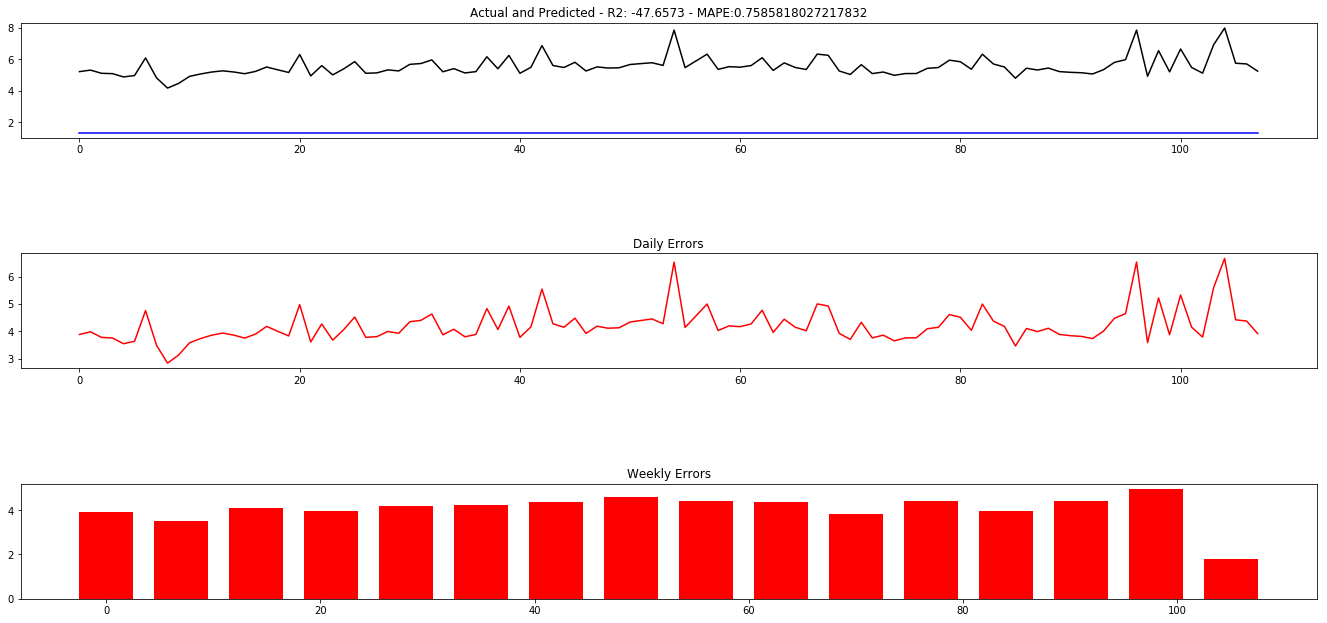

In [37]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [38]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

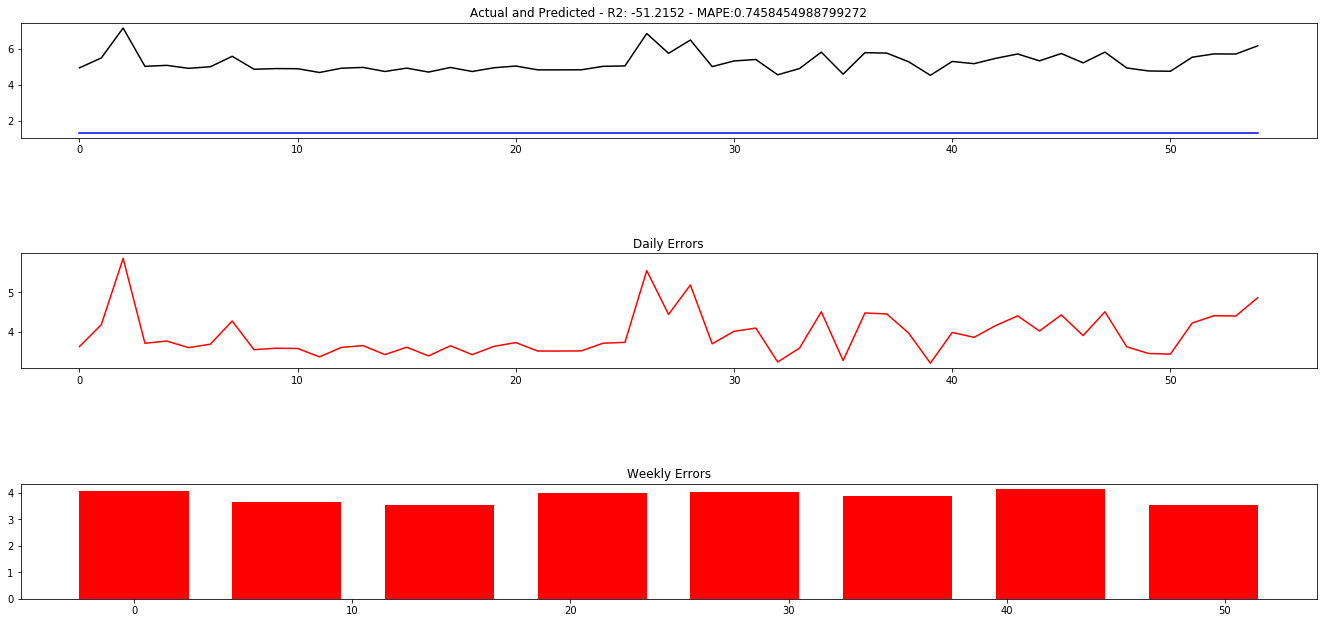

In [39]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

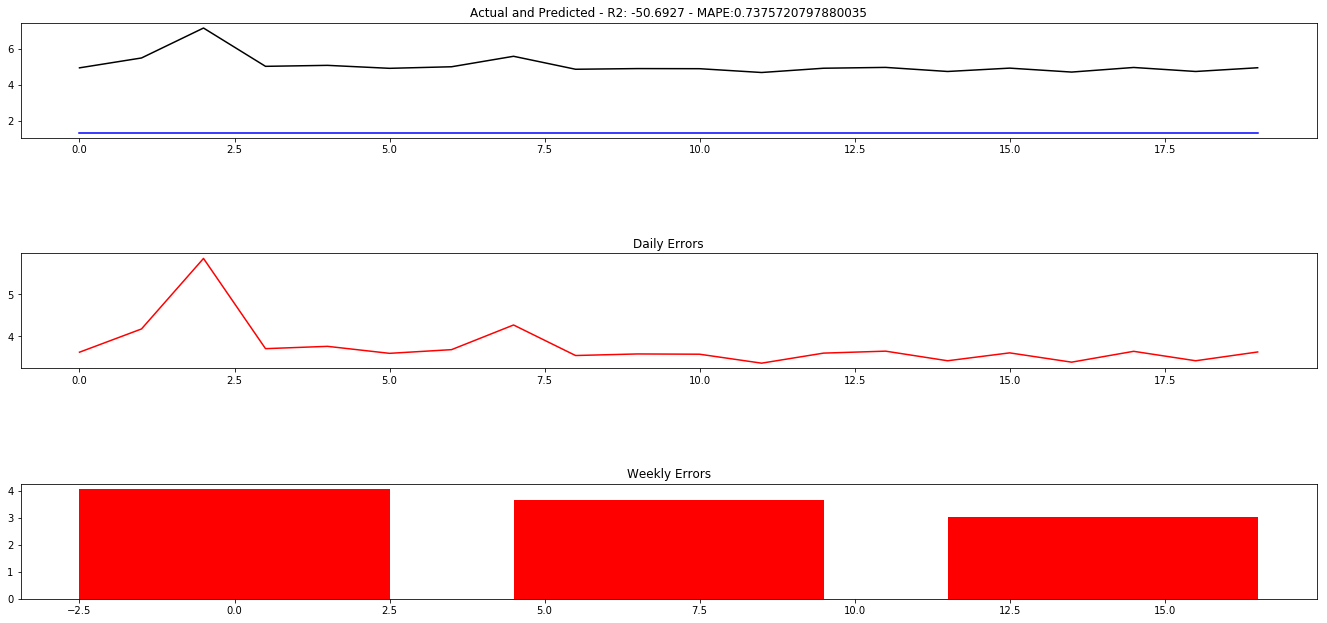

In [40]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])